# Learning predictive cognitive maps with spiking neurons during behavior and replays

In [1]:
!pip install schema

In [6]:
import numpy as np
import pylab as plt
import pickle
from matplotlib.colors import LinearSegmentedColormap
import datetime, os
from multiprocessing import Pool, cpu_count
import schema
import random
from schema import Schema, Optional, And
from types import SimpleNamespace
from matplotlib import cm
from matplotlib.colors import ListedColormap
from typing import Tuple
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax

## Important Funtions

In [7]:
def create_effective_connections(no_states: int, N_pre: int, N_pre_tot: int, N_post: int) -> np.ndarray:
    """
    For each state, we have N_pre_tot presynaptic neurons and N_post postsyn.

    For each postsynaptic neuron, we create N_pre connections out of a
    possible N_pre_tot.

    Parameters
    ----------
    no_states : int
        Number of states in the environment.
    N_pre : int
        Number of presynaptic neurons per postsynaptic neuron. This is a sub-
        set of N_pre_tot
    N_pre_tot : int
        Total number of presynaptic neurons per state.
    N_post : int
        Total number of postsysnaptic neurons per state.

    Returns
    -------
    effective_connections : np.ndarray
        Array of dimension (no_states,no_states,N_pre_tot,N_post). For each
        possible pre-to-post state, the matrix (N_pre_tot,N_post) defines
        which neurons are connected (1) and which not (0). Example:
        Connections from state 1 to state 2 are encoded in
        effective_connections[1,2,:,:], where the rows denote the possible
        presynaptic neurons and the columns denote the possible post-
        synaptic neurons. The sum of the columns are equal to N_pre.

    """
    effective_connections = []
    for kk in range(no_states):
        temp1 = []
        for ll in range(no_states):
                temp2 = []
                for mm in range(N_post):
                    temp2.append(np.random.permutation(N_pre*[1] + (N_pre_tot - N_pre)*[0]))
                temp1.append(np.transpose(temp2))
        effective_connections.append(temp1)
    effective_connections = np.array(effective_connections)
    return effective_connections

def convolution(conv: np.ndarray, tau: float, X: np.ndarray, w: float, step: float) -> np.ndarray:
    """
    Convolution operation (exponential window) updating traces.

    Parameters
    ----------
    conv : numpy.ndarray
        array with current values of the trace.
    tau : float
        timeconstant of the convolution window.
    X : numpy.ndarray
        spike times.
    w : float
        weights for the discrete steps.
    step : float
        timestep size.

    Returns
    -------
    conv : numpy.ndarray
        updated array of the traces.

    """

    conv = conv -conv/tau*step + np.multiply(X,w) - conv*(1-step/tau-np.exp(-step/tau))
    return conv

def neuron_model(epsps: np.ndarray, eps0: float,
                 step: float, v0: float,
                 current_state: int, distances: np.ndarray = np.array([])) -> np.ndarray:
    """
    Update neuron voltages and generate spikes.

    Parameters
    ----------
    epsps : np.ndarray
        array containing current voltages.
    eps0 : float
        unit epsp amplitude.
    step : float
        timestep size.
    v0 : float
        place-tuned bias input.
    current_state : int
        current state of the agent.
    distances : np array
        distances of all states to current location.

    Returns
    -------
    X : np.ndarray
        array with spikes of the current step.

    """

    u = np.sum(np.sum(epsps*eps0, axis=2), axis=0) #sum over rows (all states) and pre-population. Final dims = [n_states, N_post] or [1m1] for value neuron
    if len(distances) == 0:
        if v0>0:
            u[current_state, :] = u[current_state, :] + v0 #place tuned input for active trial
    else:
        u[:, :] = u[:, :] + v0*np.expand_dims(distances, axis=1) #*np.tile(distances, [np.size(u,axis=1),1])
    X=np.random.rand(np.size(u,axis=0), np.size(u,axis=1)) < (u*step)
    return X

def stdp(A_plus: float,
         A_minus: float,
         tau_plus: float,
         tau_minus: float,
         ca1_spike_train: np.ndarray,
         ca3_spike_train: np.ndarray,
         conv_pre: np.ndarray,
         conv_post: np.ndarray,
         step: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate spike-timing-dependent plasticity.

    Parameters
    ----------
    A_plus : float
        Amplitude of potentiation.
    A_minus : float
        Amplitude of depression.
    tau_plus : float
        Potentiation timescale.
    tau_minus : float
        Depression timescale.
    ca1_spike_train : array
        Array with spikes of CA1 neurons.
    ca3_spike_train : array
        Array with spikes of CA3 neurons.
    conv_pre : array
        Convolution of presynaptic spikes, traces to be used for STDP.
    conv_post : array
        Convolution of postsynaptic spikes, traces to be used for STDP.
    step : float
        Step size.

    Returns
    -------
    W : np.ndarray
        Synaptic weight matrix.
    conv_pre : np.ndarray
        Convolution of presynaptic spikes, traces to be used for STDP..
    conv_post : np.ndarray
        Convolution of postsynaptic spikes, traces to be used for STDP..

    """
    [no_states,no_states,N_pre]=conv_pre.shape
    N_post = np.size(conv_post,axis=2)

    #update trace
    conv_pre = convolution(conv_pre, tau_plus, ca3_spike_train, np.ones([no_states, no_states,N_pre]), step)

    #expand
    ca1_spike_train = np.tile(np.expand_dims(ca1_spike_train,axis=2),[1,1,N_pre,1])
    conv_pre_exp = np.tile(np.expand_dims(conv_pre,axis=3),[1,1,1,N_post])

    #total change in synapse due to stpd
    W = A_plus*conv_pre_exp*ca1_spike_train #+ A_minus*conv_post_exp*ca3_spike_train)
    return (W, conv_pre, conv_post)

def run_spiking_td_lambda(trajectories: list,
                  effective_connections: np.ndarray,
                  T: float,
                  step: float,
                  no_states: int,
                  N_pre: int,
                  N_pre_tot: int,
                  N_post: int,
                  rate_ca3: float,
                  eps0: float,
                  bias: float,
                  A_plus: float,
                  tau_plus: float,
                  eta_stdp: float,
                  A_pre: float,
                  tau_m: float,
                  Trials: int,
                  theta: float,
                  offline: bool = False,
                  w_init: np.ndarray = None) -> np.ndarray:
    """
    Run spiking TD lambda.

    Parameters
    ----------
    trajectories : list
        list with the trajectories.
    effective_connections : np.ndarray
        array with effective connections between CA3 and CA1.
    T : float
        Time per state visit.
    step : float
        Timestep.
    no_states : int
        Number of states of the environment.
    N_pre : int
        Number of effective presynaptic neurons per state.
    N_pre_tot : int
        Number of total presynaptic neurons per state.
    N_post : int
        Number of postsynaptic neurons per state.
    rate_ca3 : float
        CA3 firing rate when in the current state.
    eps0 : float
        Unit EPSP.
    bias : float
        Place-tuned bias current.
    A_plus : float
        STDP potentiation amplitude.
    tau_plus : float
        STDP potentiation time constant.
    eta_stdp : float
        STDP learning rate.
    A_pre : float
        STDP presynaptic depression amplitude.
    tau_m : float
        EPSP time constant.
    Trials : int
        Number of trials.
    theta : float
        Duration of the presynaptic activation when in a state.
    offline : bool, optional
        Offline weight updates (after each state visit). The default is False.
    w_init : np.ndarray, optional
        Initial weights. The default is None.

    Returns
    -------
    store_w : np.ndarray
        Stored weight evolution over time.

    """
    # Length of trajectories
    traj_len = [len(t) for t in trajectories]
    # Cumulative length of trajectories
    tot_cumulen = np.cumsum(traj_len)
    # Total number of timesteps
    T_tot = int(T*sum(traj_len)/step)
    # Randomize seed for parallel processing
    np.random.seed()

    # Initialize weight matrix
    w = w_init if w_init else np.tile(np.expand_dims(np.expand_dims(np.identity(no_states), axis=2), axis=3), [1, 1, N_pre, N_post])

    # Initialize array to store weights
    store_w = np.zeros((len(traj_len)+1, no_states, no_states, N_pre, N_post))
    store_w[0]=w*effective_connections

    # Initialize spike train arrays, spike traces arrays and epsp array
    ca3_spike_train = np.zeros([1, no_states,N_pre_tot])
    ca1_spike_train = np.zeros([1, no_states,N_post])
    conv_pre=np.zeros([no_states,no_states,N_pre_tot])
    conv_post=np.zeros([no_states,no_states,N_post])
    epsps = np.zeros((no_states, no_states,N_pre_tot,N_post))

    # Initialize trial nr, current_trial and weight change accumulation
    trial_nr = 0
    current_trial = 0
    acc_tot_dw = 0

    # progbar
    progbar = tqdm.tqdm(total=T_tot, desc="STDP Trial {}".format(trial_nr))

    # loop over all timesteps
    for i in range(T_tot):

        # calculate current trial and state
        current_trial = current_trial+i//int(T*tot_cumulen[current_trial]/step) #index current trial
        idx_current_state = i//int(T/step) - int(tot_cumulen[current_trial]) # used to find index current state
        curr_state = trajectories[current_trial][idx_current_state] #index current state
        time_state = (i%int(T/step)) #time in current state

        # CA3
        ca3_spike_train = np.zeros([1, no_states, N_pre]) #spike train from CA3 input
        ca3_spike_train[0, curr_state, :] = np.random.rand(N_pre)<(rate_ca3*step)*(time_state<int(theta/step)) #sample Poisson spike train CA3

        # CA1
        epsps = convolution(epsps, tau_m, np.tile(np.expand_dims(np.transpose(ca3_spike_train,axes=[1,0,2]),axis=3),
                                                  [1,no_states,1,N_post]), eps0*w*effective_connections, step) #epsp
        mod_bias = bias*(time_state>= int(theta/step)) # place-tuned bias current
        ca1_spike_train = neuron_model(epsps, 1, step, mod_bias, curr_state) #CA1 spike train

        #weight update
        [dw, conv_pre, conv_post] = stdp(A_plus, 0, tau_plus, 10, np.tile(ca1_spike_train, [no_states, 1, 1]),
                                    np.tile(np.transpose(ca3_spike_train,axes = [1, 0, 2]), [1, no_states, 1]), conv_pre, conv_post, step)
        tot_dw = eta_stdp*dw
        tot_dw[curr_state, :, :, :] = (tot_dw[curr_state, :, :, :] + eta_stdp*A_pre*
                                  w[curr_state, :, :, :]*np.tile(np.expand_dims(ca3_spike_train[0, curr_state, :],axis=1), [1, N_post]))

        if offline == True:
            acc_tot_dw += tot_dw
        elif offline == False:
            np.maximum(w+tot_dw,0,w) #rectify w+tot_dw and store in w
            # w = w + tot_dw
            # w[w<0]=0

        #reset between states
        if int((i+1)%int(T/step)) == 0 and offline:
            np.maximum(w+acc_tot_dw,0,w) #rectify w+tot_dw and store in w
            # w = w + acc_tot_dw
            # w[w<0]=0
            acc_tot_dw = 0

        progbar.update()

        #reset between trials
        if ((i+1)%int(tot_cumulen[current_trial]*T/step)) == 0:
            trial_nr += 1
            store_w[trial_nr] = w*effective_connections
            progbar.set_description("STDP Trial {}".format(trial_nr))
            epsps = np.zeros((no_states, no_states,N_pre_tot,N_post)) #epsps
            conv_pre=np.zeros([no_states,no_states,N_pre_tot])
            conv_post=np.zeros([no_states,no_states,N_post])

    progbar.close()
    return store_w



def calculate_parameters_var(
        effective_connections: np.ndarray,
        T: float,
        step: float,
        no_states: int,
        N_pre: int,
        N_pre_tot: int,
        N_post: int,
        rate_ca3: float,
        eps0: float,
        A_plus: float,
        tau_plus: float,
        eta_stdp: float,
        tau_m: float,
        theta: float,
        delay: float,
        verbose: bool = False,
        A_pre = None,
        ) -> Tuple[float,float,float,float]:
    """
    Calcualte TD parameters from STDP parameters.

    Parameters
    ----------
    effective_connections : np.ndarray
        array with effective connections between CA3 and CA1.
    T : float
        Time per state visit.
    step : float
        Timestep.
    no_states : int
        Number of states of the environment.
    N_pre : int
        Number of effective presynaptic neurons per state.
    N_pre_tot : int
        Number of total presynaptic neurons per state.
    N_post : int
        Number of postsynaptic neurons per state.
    rate_ca3 : float
        CA3 firing rate when in the current state.
    eps0 : float
        Unit EPSP.
    A_plus : float
        STDP potentiation amplitude.
    tau_plus : float
        STDP potentiation time constant.
    eta_stdp : float
        STDP learning rate.
    tau_m : float
        EPSP time constant.
    theta : float
        Duration of the presynaptic activation when in a state.
    delay : float
        Time after theta until next state (delay is T-theta).

    Returns
    -------
    Tuple[float,float,float,float]
        Returns the TD parameters gamma, lambda, eta as well as the bias current.

    """
    # Total time in a state
    T = theta + delay

    # Calculation for parameter A
    A1 = N_pre*rate_ca3*(1-np.exp(-theta/tau_m))*(theta-tau_plus*(1-np.exp(-theta/tau_plus)))
    # A1 = 1*rate_ca3*(1-np.exp(-theta/tau_m))*(theta-tau_plus*(1-np.exp(-theta/tau_plus)))
    A2 = theta/((tau_m+tau_plus))

    # Depression amplitude
    max_ltd = - A_plus*tau_m*tau_plus*(A1+A2)/theta

    if not A_pre:
        A_pre = max_ltd - 5

    A_LTD = A_pre*rate_ca3*theta

    # Parameter A
    A = eta_stdp*(eps0*A_plus*rate_ca3*tau_m*tau_plus*(A1+A2) + A_LTD)
    # A = eta_stdp*(1*A_plus*rate_ca3*tau_m*tau_plus*(A1+A2) + A_LTD)

    # Parameter C
    C = eps0*eta_stdp*A_plus*rate_ca3*tau_plus*(np.exp(theta/tau_plus)-1)*N_pre*rate_ca3*tau_m*(1-np.exp(-theta/tau_m))*tau_plus*(1-np.exp(-theta/tau_plus))
    # C = 1*eta_stdp*A_plus*rate_ca3*tau_plus*(np.exp(theta/tau_plus)-1)*1*rate_ca3*tau_m*(1-np.exp(-theta/tau_m))*tau_plus*(1-np.exp(-theta/tau_plus))

    # Learning rate
    eta = -A

    # Lambda
    lambda_var = 1/(1+C/eta)

    # Gamma
    gamma_var = np.exp(-T/tau_plus)/lambda_var

    # Parameter D
    D = eta_stdp*rate_ca3*A_plus*tau_plus*(1-np.exp(-theta/tau_plus))*tau_plus*(1-np.exp(-(T-theta)/tau_plus))

    # Bias current
    bias = -A/D

    if verbose:
        print('Is A_pre < min? {}'.format( A_pre < max_ltd))
        print('A_pre: {}'.format(A_pre))
        print('max_ltd: {}'.format(max_ltd))
        print('Lambda: {}'.format(lambda_var))
        print('Gamma: {}'.format(gamma_var))
        print('eta: {}'.format(eta))
        print('bias: {}'.format(bias))
        print('LTD: {}'.format(A_LTD*eta_stdp))
        print('LTP: {}'.format(eta_stdp*(eps0*A_plus*rate_ca3*tau_m*tau_plus*(A1+A2))))

    return gamma_var, lambda_var, eta, bias, A_pre

def keep_gamma_eta_same(
        effective_connections: np.ndarray,
        T: float,
        step: float,
        no_states: int,
        N_pre: int,
        N_pre_tot: int,
        N_post: int,
        rate_ca3: float,
        eps0: float,
        A_plus: float,
        tau_plus: float,
        eta_stdp: float,
        tau_m: float,
        theta: float,
        delay: float,
        gamma_target: float,
        eta_target: float) -> Tuple[float,float,float,float,float,float,float]:
    """
    Calcualte STDP parameters from TD parameters eta and gamma.

    Parameters
    ----------
    effective_connections : np.ndarray
        array with effective connections between CA3 and CA1.
    T : float
        Time per state visit.
    step : float
        Timestep.
    no_states : int
        Number of states of the environment.
    N_pre : int
        Number of effective presynaptic neurons per state.
    N_pre_tot : int
        Number of total presynaptic neurons per state.
    N_post : int
        Number of postsynaptic neurons per state.
    rate_ca3 : float
        CA3 firing rate when in the current state.
    eps0 : float
        Unit EPSP.
    A_plus : float
        STDP potentiation amplitude.
    tau_plus : float
        STDP potentiation time constant.
    eta_stdp : float
        STDP learning rate.
    tau_m : float
        EPSP time constant.
    theta : float
        Duration of the presynaptic activation when in a state.
    delay : float
        Time after theta until next state (delay is T-theta).
    gamma_target: float
        Target value for TD parameter gamma (discount)
    eta_target: float
        Target value for TD parameter eta (learning rate)

    Returns
    -------
    Tuple[float,float,float,float]
        Returns the TD parameters gamma, lambda, eta as well as the bias current.

    """
    A1 = N_pre*rate_ca3*(1-np.exp(-theta/tau_m))*(theta-tau_plus*(1-np.exp(-theta/tau_plus)))
    A2 = theta/((tau_m+tau_plus))
    LTP = eta_stdp*eps0*(A_plus*rate_ca3*tau_m*tau_plus*(A1+A2))
    # Costraint 1
    A_pre =   -(eta_target + LTP)/(eta_stdp*rate_ca3*theta)
    A_LTD = eta_stdp*A_pre*rate_ca3*theta
    max_ltd = - eps0*A_plus*tau_m*tau_plus*(A1+A2)/theta
    A = LTP + A_LTD
    C = eps0*eta_stdp*A_plus*rate_ca3*tau_plus*(np.exp(theta/tau_plus)-1)*N_pre*rate_ca3*tau_m*(1-np.exp(-theta/tau_m))*tau_plus*(1-np.exp(-theta/tau_plus))
    # Costraint 2
    const = (1-C/A)*np.exp(-theta/tau_plus)
    delay = tau_plus*(-np.log(gamma_target) + np.log(const))
    T = theta + delay

    gamma_var, lambda_var, eta, bias, _ = calculate_parameters_var(effective_connections,T, step, no_states,
                  N_pre, N_pre_tot, N_post, rate_ca3, eps0, A_plus,
                   tau_plus, eta_stdp, tau_m, theta, delay)
#    eta = -A
#    lambda_var = 1/(1+C/eta)
#    gamma_var = np.exp(-T/tau_plus)/lambda_var
#
    D = eta_stdp*rate_ca3*A_plus*tau_plus*(1-np.exp(-theta/tau_plus))*tau_plus*(1-np.exp(-(T-theta)/tau_plus))*bias
#    gamma_var = np.exp(-T/tau_plus)/lambda_var
#    bias = -A/D
    LTP = eta_stdp*eps0*(A_plus*rate_ca3*tau_m*tau_plus*(A1+A2))
    b = - A_plus*tau_m*tau_plus*(rate_ca3 + 1/(tau_m+tau_plus))
    A_LTD = eta_stdp*A_pre*rate_ca3*theta
    min_cond = min(max_ltd, b)

    return gamma_var, lambda_var, eta, A_pre, delay, T, bias


def calculate_parameters_TD_new(
        T: float,
        step: float,
        no_states: int,
        N_pre: int,
        N_pre_tot: int,
        N_post: int,
        rate_ca3: float,
        eps0: float,
        A_plus: float,
        tau_plus: float,
        eta_stdp: float,
        tau_m: float,
        Trials: int,
        theta: float,
        ) -> Tuple[float,float,float,float,float,float,float]:
    """
    Calcualte STDP parameters.

    Parameters
    ----------
    T : float
        Time per state visit.
    step : float
        Timestep.
    no_states : int
        Number of states of the environment.
    N_pre : int
        Number of effective presynaptic neurons per state.
    N_pre_tot : int
        Number of total presynaptic neurons per state.
    N_post : int
        Number of postsynaptic neurons per state.
    rate_ca3 : float
        CA3 firing rate when in the current state.
    eps0 : float
        Unit EPSP.
    A_plus : float
        STDP potentiation amplitude.
    tau_plus : float
        STDP potentiation time constant.
    eta_stdp : float
        STDP learning rate.
    tau_m : float
        EPSP time constant.
    Trials : int
        Number of trials.
    theta : float
        Duration of the presynaptic activation when in a state.
    delay : float
        Time after theta until next state (delay is T-theta).
    gamma_target: float
        Target value for TD parameter gamma (discount)
    eta_target: float
        Target value for TD parameter eta (learning rate)

    Returns
    -------
    Tuple[float,float,float,float]
        Returns the TD parameters gamma, lambda, eta as well as the bias current.

    """
    A1 = rate_ca3*(1-np.exp(-theta/tau_m))*(theta-tau_plus*(1-np.exp(-theta/tau_plus)))*N_pre
    A2 = theta/((tau_m+tau_plus))
    max_ltd = A_plus*tau_m*tau_plus*(A1+A2)/theta

    A_pre = -max_ltd-5  # subtract by 5 to ensure positive learning rate

    # Calculate A
    A_LTD = A_pre*rate_ca3*theta
    A = eta_stdp*eps0*(A_plus*rate_ca3*tau_m*tau_plus*(A1+A2) + A_LTD)

    # Calculate D
    D = eta_stdp*rate_ca3*A_plus*tau_plus*(1-np.exp(-theta/tau_plus))*tau_plus*(1-np.exp(-(T-theta)/tau_plus))

    # Calculate C
    C = eta_stdp*A_plus*rate_ca3*tau_plus*(np.exp(theta/tau_plus)-1)*N_pre*rate_ca3*tau_m*(1-np.exp(-theta/tau_m))*tau_plus*(1-np.exp(-theta/tau_plus))

    # Calculate parameters TD
    eta_var = -A
    lambda_var = 1/(1+C/eta_var)
    gamma_var = np.exp(-T/tau_plus)/lambda_var

    # Calculate background firing rate
    bias = -A/D

    return eta_var, lambda_var, gamma_var, bias, A_pre

def parameters_linear_track(no_states: int) -> Tuple[dict,float,float,float]:
    """
    Generate parameters for the linear track.

    Parameters
    ----------
    no_states: int
        Number of states in the linear track.

    Returns
    -------
    Tuple[dict,float,float,float]
        Return a parameters dictionary, and the parameters for the
        theoretical TD lambda.

    """
    params = {
           'A_plus': 1,
           'T': 100,
           'eta_stdp': 0.003, #0.002
           'no_states': no_states,
           'rate_ca3': 0.1,
           'step': 0.01,
           'tau_m': 2,
           'tau_plus': 60, #20
           'N_post':1,
           'N_pre_tot':1,
           'N_pre':1,
           'theta': 80, #200
           }
    params['eps0'] = 1/params['N_pre']
    params['delay'] = params['T'] - params['theta']
    params['effective_connections'] = create_effective_connections(params['no_states'], params['N_pre'], params['N_pre_tot'], params['N_post'])

    gamma, lam, eta, params["bias"], params["A_pre"] = calculate_parameters_var(**params)



    del params['delay']
    return params, gamma, eta, lam

def parameters_linear_track_value(no_states: int, T: int, alpha: float, A_pre: int) -> Tuple[dict,float,float,float]:
    """
    Generate parameters for the linear track.

    Parameters
    ----------
    no_states: int
        Number of states in the linear track.

    Returns
    -------
    Tuple[dict,float,float,float]
        Return a parameters dictionary, and the parameters for the
        theoretical TD lambda.

    """
    params = {
           'A_plus': 1,
           'T': T,
           'eta_stdp': 0.003,
           'no_states': no_states,
           'rate_ca3': 0.1,
           'step': 0.01,
           'tau_m': 2,
           'tau_plus': 60,
           'N_post':250, #250
           'N_pre_tot':1000, #1000
           'N_pre':250, #250
           'theta': alpha*T,
           }
    params['eps0'] = 1/params['N_pre']
    params['delay'] = (1-alpha)*params['T']
    params['effective_connections'] = create_effective_connections(params['no_states'], params['N_pre'], params['N_pre_tot'], params['N_post'])

    gamma, lam, eta, params["bias"], params["A_pre"] = calculate_parameters_var(**params, A_pre = A_pre)


    del params['delay']
    return params, gamma, eta, lam

def parameters_linear_track_population(rate, tau_plus, tau_m, no_states: int) -> Tuple[dict,float,float,float]:
    """
    Generate parameters for the linear track.

    Parameters
    ----------
    no_states: int
        Number of states in the linear track.

    Returns
    -------
    Tuple[dict,float,float,float]
        Return a parameters dictionary, and the parameters for the
        theoretical TD lambda.

    """
    params = {
           'A_plus': 1,
           'T': 100,
           'eta_stdp': 0.001,
           'no_states': no_states,
           'rate_ca3': rate, #0.1,
           'step': 0.01,
           'tau_m': tau_m, #2,
           'tau_plus': tau_plus, #200,
           'N_post':10, #250
           'N_pre_tot':50, #1000
           'N_pre':10, #250
           'theta': 80,
           }
    params['eps0'] = 1/params['N_pre']
    params['delay'] = params['T'] - params['theta']
    params['effective_connections'] = create_effective_connections(params['no_states'], params['N_pre'], params['N_pre_tot'], params['N_post'])

    gamma, lam, eta, params["bias"], params["A_pre"] = calculate_parameters_var(**params)

    del params['delay']
    return params, gamma, eta, lam


def TD_lambda_update(
        curr_state: int,
        next_state: int,
        gamma: float,
        lam: float,
        alpha: float,
        elig_trace: np.ndarray,
        M: np.ndarray
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    TD lambda update.

    Parameters
    ----------
    curr_state : int
        current state.
    next_state : int
        next state.
    gamma : float
        delay discount parameter.
    lam : float
        TD lambda parameter.
    alpha : float
        learning rate.
    elig_trace : np.ndarray
        eligibility trace.
    M : np.ndarray
        successor matrix.

    Returns
    -------
    M : np.ndarray
        updated successor matrix.
    elig_trace : np.ndarray
        updated eligibility traces.

    """
    n_states = np.shape(M)[0]
    one_vector = np.zeros(n_states)
    one_vector[curr_state] = 1
    elig_trace = lam*gamma*elig_trace + 1*one_vector
    pred_error = one_vector + gamma*M[next_state] - M[curr_state]
    M = M + alpha*np.outer(elig_trace, pred_error)
    return M, elig_trace

def theor_trajectory(trajectory: list,
                    n_states: int,
                    gamma: float,
                    lam: float,
                    alpha: float,
                    M=None) -> np.ndarray:
    """
    Run theoretical TD lambda on one trajectory.

    Parameters
    ----------
    trajectory : list
        trajectory to be run.
    n_states : int
        number of states in the environment.
    gamma : float
        discount parameter.
    lam : float
        lambda parameter regulating TD(lambda).
    alpha : float
        learning rate.
    M : TYPE, optional
        initial successor matrix. The default is None.

    Returns
    -------
    M : np.ndarray
        final successor matrix.

    """
    # Initialize SR matrix and SR matrix storing var
    if M is None:
        M = np.eye(n_states)
    # Initialize eligibility trace
    elig_trace = np.zeros(n_states)

    # loop over states
    for curr_state, next_state in zip(trajectory[:-1], trajectory[1:]):
        M, elig_trace = TD_lambda_update(
                            curr_state,
                            next_state,
                            gamma,
                            lam,
                            alpha,
                            elig_trace,
                            M
                            )

    return M

def theor_TD_lambda(trajectories: list,
                    n_states: int,
                    gamma: float,
                    lam: float,
                    alpha: float,
                    M=None) -> np.ndarray:
    """
    Run theoretical TD lambda for multiple trajectories.

    Parameters
    ----------
    trajectories : list
        list of trajectories.
    n_states : int
        number of states in the environment.
    gamma : float
        discount parameter.
    lam : float
        lambda parameter regulating TD(lambda).
    alpha : float
        learning rate.
    M : TYPE, optional
        initial successor matrix. The default is None.

    Returns
    -------
    store_M : np.ndarray
        final successor matrix after each trial.

    """
    # Initialize SR matrix and SR matrix storing var
    if M is None:
        M = np.eye(n_states)
    n_trials = len(trajectories)
    store_M = np.zeros((n_trials, n_states, n_states))
    store_M[0] = M

    # progress bar
    progbar = tqdm.tqdm(total=n_trials, desc="TD Trial {}".format(0))

    # Loop over trials
    for trial in range(n_trials):
        # Get current trajectory
        curr_traj = trajectories[trial]

        M = theor_trajectory(curr_traj,
                    n_states,
                    gamma,
                    lam,
                    alpha,
                    M)

        # Store M at the end of each trial
        store_M[trial] = M
        progbar.set_description( "TD Trial {}".format(trial+1))
    progbar.close()
    return store_M




def run_MC(trajectories, temporal_between,temporal_same, effective_connections, T, step, no_states, N_pre, N_pre_tot, N_post, rate_ca3, eps0, bias, A_plus,
                   tau_plus, eta_stdp, A_pre, tau_m,
                  pre_offset, theta, w = [], ini='identity',spike_noise_prob=0.2):#(trajectories,w,temporal_between,temporal_same, tau_m, Trials, pre_offset, A_pre, T, no_states, bias,
                   # A_minus,tau_minus,A_plus,tau_plus,eta_stdp,step,N_pre_tot,N_post,N_pre,eps0,store_w,store_w_end):

    #no_states = np.size(w,axis=0)
    np.random.seed() #randomize seed for parallel

    store1, store2 = [], []

    T = temporal_between #time in each state
    same_loc = temporal_same
    A_pre = -A_plus*np.exp(-(same_loc)/tau_plus)
    T_tot = int(T/step)

    if w == []:
        init = np.identity(no_states) if ini=='identity' else 2*np.random.rand(no_states,no_states)
        w_init = np.tile(np.expand_dims(np.expand_dims(init, axis=2), axis=3), [1, 1, N_pre_tot, N_post])
        w = w_init*effective_connections
    store_w = []
    store_w_end = []

#    for traj in trajectories:

    #noise_steps = 4
    interval_range = 50 # in units of steps, default step is 0.01 ms

    assert interval_range < int(same_loc/step), 'wrong interval_range?'

    wavg = []

    print('Calculating TD(1) spiking ....')

    # For loop over epochs in trajectory
    for epoch in trajectories:

        trial_len = len(epoch)

        conv_pre=np.zeros([no_states,no_states,N_pre_tot])
        conv_post=np.zeros([no_states,no_states,N_post])

        w_offline = 0


#        noise1 = - np.random.randint(noise_steps)
#        noise2 = 0
        # For loop over states in trial
        for j in range(trial_len):
            curr_state = epoch[j] #index current state

            p = spike_noise_prob

            #choose with probability p two pre spikes, otherwise 1
            n_pre_spikes = np.random.binomial(1, p)+1
            # if 2 spikes, choose with 50% probability to use two spikes, otherwise 0
            if n_pre_spikes == 2:
                n_pre_spikes = np.random.binomial(1, 0.5)*2


            #choose with probability p two post spikes
            n_post_spikes =np.random.binomial(1, p)+1
            # if 2 spikes, choose with 50% probability to use two spikes, otherwise 0
            if n_post_spikes == 2:
                n_post_spikes = np.random.binomial(1, 0.5)*2

            times_pre = np.random.choice(np.arange(0, interval_range), n_pre_spikes)
            times_post = np.random.choice(np.arange(int(same_loc/step), interval_range + int(same_loc/step)), n_post_spikes)


            for i in np.arange(T_tot):

                ca3_spike_train = np.zeros([1, no_states,N_pre_tot])
                ca1_spike_train = np.zeros([1, no_states,N_post])


                if i in times_pre:#(i+noise1)%(T/step)==0: #or (i+1)%(T/step)==0 or (i+2)%(T/step)==0:
                    spike_ca3 = 1#np.random.rand() < 1
                    spike_ca1 = 0
                    #noise2 = - np.random.randint(noise_steps)

                elif i in times_post:#(((i+noise2)-int(same_loc/step))%(T/step)==0): #or (((i+1)-int(same_loc/step))%(T/step)==0) or (((i+2)-int(same_loc/step))%(T/step)==0):
                    spike_ca1 = 1#np.random.rand() < 1
                    spike_ca3 = 0
                    #noise1 = - np.random.randint(noise_steps)
            #
                else:
                    spike_ca3 = 0
                    spike_ca1 = 0

                ca3_spike_train[0,curr_state,:]= spike_ca3#(i%(T/step)==0)*1
                ca1_spike_train[0,curr_state,:] = spike_ca1#((i-int(same_loc/step))%(T/step)==0)*1

                #weight update
                [dw, conv_pre, conv_post]=stdp(A_plus, 0, tau_plus, 10, np.tile(ca1_spike_train,[no_states,1,1]),
                                        np.tile(np.transpose(ca3_spike_train,axes=[1,0,2]),[1,no_states,1]), conv_pre, conv_post, step)
                tot_dw = eta_stdp*dw

                tot_dw[curr_state, :, :, :] = (tot_dw[curr_state, :, :, :] + eta_stdp*A_pre*
                                          w[curr_state, :, :, :]*np.tile(np.expand_dims(ca3_spike_train[0, curr_state, :],axis=1), [1, N_post]))


                w_offline = w_offline + tot_dw
                w = w + tot_dw
                w[w<0]=0


#                if spike_ca1==1:
#                    break
#            w = w + w_offline
#            w[w<0]=0

        wavg.append(np.mean(np.sum(w[:,:,:,:],axis=2)/N_pre,axis=2))
        store_w.append(np.mean(wavg,axis=0))
        store_w_end.append(np.mean(np.sum(w[:,:,:,:],axis=2)/N_pre,axis=2))

        store1.append(store_w_end[-1][0][0])
        store2.append(store_w_end[-1][1][2])

    return store_w_end, store1, store2




def run_td_lambda_new_continuousTime(trajectories, effective_connections, T_lists, step, no_states,
                  N_pre, N_pre_tot, N_post, rate_ca3, eps0, bias, A_plus,
                   tau_plus, eta_stdp, A_pre, tau_m,
                  theta, offline=False,w=[],ini='identity',state_3_rate=1):

    traj_len = [len(t) for t in T_lists]
    tot_cumulen = np.cumsum(traj_len)
    Trials = len(T_lists)
    T_tot = int(sum([sum(x) for x in T_lists])/step)

    np.random.seed() #randomize seed for parallel
    store1, store2 = [], []
    store_w_end = []
    
    #initialize weight matrix
    if w == []:
        init = np.identity(no_states) if ini=='identity' else 2*np.random.rand(no_states,no_states)
        w_init = np.tile(np.expand_dims(np.expand_dims(init, axis=2), axis=3), [1, 1, N_pre_tot, N_post])
        w = w_init

    store_w = np.zeros((sum(traj_len)+1, no_states, no_states, N_pre_tot, N_post))
    store_w[0]=w*effective_connections

    # initialize
    ca3_spike_train = np.zeros([1, no_states,N_pre_tot]) #spike train from CA3 input
    ca1_spike_train = np.zeros([1, no_states,N_post])
    conv_pre=np.zeros([no_states,no_states,N_pre_tot])
    conv_post=np.zeros([no_states,no_states,N_post])
    epsps = np.zeros((no_states, no_states,N_pre_tot,N_post)) #epsps

    trial_nr = 0
    print('Calculating TD lambda spiking ....')

    current_trial = 0
    acc_tot_dw = 0
    idx_current_state = 0

    pot = np.empty_like(w)*0
    dep = np.empty_like(w)*0

    cumul_trials = 0
    Trial_tot_t = 0
    prev_trial = 0
    prev_state = 0
    state_counter = 0

    for i in range(T_tot):

        T = T_lists[current_trial][idx_current_state]
        Ts_trial = [t/step for t in T_lists[current_trial]]
        Trial_tot_t = sum(Ts_trial)

        # calculate current trial and state
        states_trial = [y for y,x in enumerate(T_lists[current_trial]) for _ in range(int(x/step)) ]
        assert Trial_tot_t == len(states_trial), f'somthing wrong {Trial_tot_t} vs {len(states_trial)}'

        prev_trial = current_trial
        current_trial = prev_trial+int((i)//(cumul_trials+int(Trial_tot_t))) #index current trial

        if prev_trial != current_trial:
            cumul_trials += Trial_tot_t

        t_trial = int(i - cumul_trials)

        prev_state = idx_current_state
        idx_current_state = states_trial[t_trial]

        # print(f'idx_current_state {idx_current_state}')
        curr_state = trajectories[current_trial][idx_current_state] #index current state
        t_start_state = states_trial.index(idx_current_state)

        time_state = t_trial - t_start_state #time in current state

        # CA3
        ca3_spike_train = np.zeros([1, no_states, N_pre_tot]) #spike train from CA3 input

        if idx_current_state == 2:
            rate_ca3_s = rate_ca3*state_3_rate
        else:
            rate_ca3_s = rate_ca3

        ca3_spike_train[0, curr_state, :] = np.random.rand(N_pre_tot)<(rate_ca3_s*step)*(time_state<int(theta/step)) #sample Poisson spike train CA3

        # CA1
        epsps = convolution(epsps, tau_m, np.tile(np.expand_dims(np.transpose(ca3_spike_train,axes=[1,0,2]),axis=3),
                                                  [1,no_states,1,N_post]), w*effective_connections, step) #epsp
        mod_bias = bias*(time_state>= int(theta/step))
        #store_bias[i] = (mod_bias)
        if time_state == int(theta/step):
            epsps = np.zeros((no_states, no_states,N_pre_tot,N_post)) #epsps

        ca1_spike_train = neuron_model(epsps, eps0/N_pre, step, mod_bias, curr_state) #CA1 spike train

        #weight update
        [dw, conv_pre, conv_post] = stdp(A_plus, 0, tau_plus, 10, np.tile(ca1_spike_train, [no_states, 1, 1]),
                                    np.tile(np.transpose(ca3_spike_train,axes = [1, 0, 2]), [1, no_states, 1]), conv_pre, conv_post, step)
        tot_dw = eta_stdp*dw
        pot += eta_stdp*dw
        dep[curr_state, :, :, :] += eta_stdp*eps0*A_pre* w[curr_state, :, :, :]*np.tile(np.expand_dims(ca3_spike_train[0, curr_state, :],axis=1), [1, N_post])
        tot_dw[curr_state, :, :, :] = (tot_dw[curr_state, :, :, :] + eta_stdp*eps0*A_pre*
                                  w[curr_state, :, :, :]*np.tile(np.expand_dims(ca3_spike_train[0, curr_state, :],axis=1), [1, N_post]))

        if offline == True:
            acc_tot_dw += tot_dw
        elif offline == False:
            w = w + tot_dw#*np.abs(w_init-1)
            w[w<0]=0

        #reset between states
        if prev_state != idx_current_state:

            if offline == True:
                w = w + acc_tot_dw #*np.abs(w_init-1)
                w[w<0]=0
                acc_tot_dw = 0

            store_w[state_counter, :, :, :, :] = w*effective_connections

            state_counter += 1
            pot = np.empty_like(w)*0
            dep = np.empty_like(w)*0
        #reset between trials
        if prev_trial != current_trial:


            trial_nr += 1

            # print(f'trial nr: {trial_nr}')
            epsps = np.zeros((no_states, no_states,N_pre_tot,N_post)) #epsps
            conv_pre=np.zeros([no_states,no_states,N_pre_tot])
            conv_post=np.zeros([no_states,no_states,N_post])
            store_w_end.append(np.mean(np.sum(w[:,:,:,:],axis=2)/N_pre,axis=2))
            store1.append(store_w_end[-1][0][0])
            store2.append(store_w_end[-1][1][2])

    
    store_w[state_counter+1, :, :, :, :] = w*effective_connections
    return store_w , store1, store2

def run_value_function(trajectories, effective_connections, T_lists, step, no_states,
                  N_pre, N_pre_tot, N_post, rate_ca3, eps0, bias, A_plus,
                   tau_plus, eta_stdp, A_pre, tau_m,
                  theta, wini, reward_vec, offline=False,):


        assert no_states == len(reward_vec), 'ERROR: reward_vec should have length equal to no_states'
        assert np.shape(wini) == (no_states, no_states, N_pre_tot, N_post), 'ERROR: initial weights wini should have shape (no_states, no_states, N_pre_tot, N_post)'

        traj_len = [len(t) for t in T_lists]
        tot_cumulen = np.cumsum(traj_len)
        Trials = len(T_lists)
        T_tot = int(sum([sum(x) for x in T_lists])/step)

        np.random.seed() #randomize seed for parallel

        #initialize weight matrix
        w = wini

        # initialize
        ca3_spike_train = np.zeros([1, no_states,N_pre_tot]) #spike train from CA3 input
        ca1_spike_train = np.zeros([1, no_states,N_post])
        epsps = np.zeros((no_states, no_states,N_pre_tot,N_post)) #epsps

        nr_value_neurons = 250
        v_spike_train = np.zeros([nr_value_neurons])
        epsps_v = np.zeros((no_states,1,N_post,nr_value_neurons))

        trial_nr = 0
        print('Calculating TD lambda spiking ....')

        current_trial = 0
        idx_current_state = 0

        cumul_trials = 0
        Trial_tot_t = 0
        prev_trial = 0
        prev_state = 0
        state_counter = 0

        reward_neuron = np.zeros((no_states, nr_value_neurons, T_tot))

        for i in tqdm.tqdm(range(T_tot)):

            T = T_lists[current_trial][idx_current_state]
            Ts_trial = [t/step for t in T_lists[current_trial]]
            Trial_tot_t = sum(Ts_trial)

            # calculate current trial and state
            states_trial = [y for y,x in enumerate(T_lists[current_trial]) for _ in range(int(x/step)) ]
            assert Trial_tot_t == len(states_trial), f'somthing wrong {Trial_tot_t} vs {len(states_trial)}'

            prev_trial = current_trial
            current_trial = prev_trial+int((i)//(cumul_trials+int(Trial_tot_t))) #index current trial

            if prev_trial != current_trial:
                cumul_trials += Trial_tot_t

            t_trial = int(i - cumul_trials)

            prev_state = idx_current_state
            idx_current_state = states_trial[t_trial]

            # print(f'idx_current_state {idx_current_state}')
            curr_state = trajectories[current_trial][idx_current_state] #index current state
            t_start_state = states_trial.index(idx_current_state)

            time_state = t_trial - t_start_state #time in current state

            # CA3
            ca3_spike_train = np.zeros([1, no_states, N_pre_tot]) #spike train from CA3 input

            if idx_current_state == 2:
                rate_ca3_s = rate_ca3#*0.5
            else:
                rate_ca3_s = rate_ca3

            ca3_spike_train[0, curr_state, :] = np.random.rand(N_pre_tot)<(rate_ca3_s*step)*(time_state<int(theta/step)) #sample Poisson spike train CA3

            # CA1
            # transpose to dims [n_states, 1, N_pre_tot, 1]
            # tile to dims [n_states, n_states, N_pre_tot, N_post]
            # element-wise multiplication with weights w
            epsps = convolution(epsps, tau_m, np.tile(np.expand_dims(np.transpose(ca3_spike_train,axes=[1,0,2]),axis=3),
                                                      [1,no_states,1,N_post]), w*effective_connections, step) #epsp


            mod_bias = bias*(time_state>= int(theta/step))

            ca1_spike_train = neuron_model(epsps, eps0, step, mod_bias, curr_state) #CA1 spike train

            # VALUE
            # ca1_spike_train has dim [n_states, n_post] and is reshapen to dims [n_states, 1, n_post, 1]
            # reward_vec has dims [n_states] and is reshapen to [n_states, 1, n_post, nr_value_neurons]
            #
            #
            rew_weights = np.tile(np.expand_dims(np.expand_dims(np.expand_dims(reward_vec,1),2),3), [1,1,N_post,nr_value_neurons])
            epsps_v = convolution(epsps_v, tau_m, np.expand_dims(np.expand_dims(ca1_spike_train,axis=1),axis=3), rew_weights, step) #epsp
            value_spike_train = neuron_model(epsps_v, eps0*N_pre/N_post, step, 0, curr_state) #VALUE spike train
            if curr_state != prev_state:
                print(curr_state)
            reward_neuron[curr_state, :, i] = value_spike_train

        return reward_neuron

def run_Q_learning(trajectories, temporal_between, temporal_same, effective_connections, 
                  alpha, gamma, epsilon, T, step, no_states, N_pre, N_pre_tot, N_post, 
                  rate_ca3, eps0, bias, A_plus, tau_plus, eta_stdp, A_pre, tau_m,
                  pre_offset, theta, w=[], ini='identity', spike_noise_prob=0.2):
    """
    Q-learning variant for successor representations with spiking neural network implementation
    
    Parameters:
    - alpha: learning rate for Q-learning
    - gamma: discount factor
    - epsilon: exploration rate
    - Other parameters same as MC version
    """
    np.random.seed()
    
    T = temporal_between
    same_loc = temporal_same
    A_pre = -A_plus * np.exp(-(same_loc)/tau_plus)
    T_tot = int(T/step)
    
    # Initialize weights
    if w == []:
        init = np.identity(no_states) if ini=='identity' else 2*np.random.rand(no_states,no_states)
        w_init = np.tile(np.expand_dims(np.expand_dims(init, axis=2), axis=3), 
                        [1, 1, N_pre_tot, N_post])
        w = w_init * effective_connections
    
    # Initialize Q-table
    Q = np.zeros((no_states, no_states))
    store_w = []
    store_w_end = []
    interval_range = 50

    store1, store2 = [], []
    
    print('Running Q-learning with spiking neurons...')
    
    for epoch in trajectories:
        epoch = np.append(epoch, epoch[len(epoch) - 1])
        trial_len = len(epoch)
        conv_pre = np.zeros([no_states, no_states, N_pre_tot])
        conv_post = np.zeros([no_states, no_states, N_post])
        w_offline = 0
        
        for j in range(trial_len-1):  # -1 because we need next state for Q-learning
            curr_state = epoch[j]
            next_state = epoch[j+1]
            
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.randint(0, no_states)
            else:
                action = np.argmax(Q[curr_state])
            
            # Generate spikes with noise
            n_pre_spikes = np.random.binomial(1, spike_noise_prob) + 1
            if n_pre_spikes == 2:
                n_pre_spikes = np.random.binomial(1, 0.5) * 2
                
            n_post_spikes = np.random.binomial(1, spike_noise_prob) + 1
            if n_post_spikes == 2:
                n_post_spikes = np.random.binomial(1, 0.5) * 2
            
            times_pre = np.random.choice(np.arange(0, interval_range), n_pre_spikes)
            times_post = np.random.choice(np.arange(int(same_loc/step), 
                                                  interval_range + int(same_loc/step)), 
                                        n_post_spikes)
            
            # Simulate spikes and update weights
            for i in np.arange(T_tot):
                ca3_spike_train = np.zeros([1, no_states, N_pre_tot])
                ca1_spike_train = np.zeros([1, no_states, N_post])
                
                spike_ca3 = 1 if i in times_pre else 0
                spike_ca1 = 1 if i in times_post else 0
                
                ca3_spike_train[0, curr_state, :] = spike_ca3
                ca1_spike_train[0, curr_state, :] = spike_ca1
                
                # STDP weight update
                [dw, conv_pre, conv_post] = stdp(A_plus, 0, tau_plus, 10,
                                               np.tile(ca1_spike_train, [no_states,1,1]),
                                               np.tile(np.transpose(ca3_spike_train,axes=[1,0,2]),
                                                     [1,no_states,1]), 
                                               conv_pre, conv_post, step)
                tot_dw = eta_stdp * dw
                
                # Add pre-synaptic contribution
                tot_dw[curr_state, :, :, :] = (tot_dw[curr_state, :, :, :] + 
                                             eta_stdp * A_pre * w[curr_state, :, :, :] * 
                                             np.tile(np.expand_dims(ca3_spike_train[0, curr_state, :],
                                                                 axis=1), [1, N_post]))
                
                # Q-learning update
                reward = np.sum(tot_dw[curr_state, action]) / (N_pre * N_post)  # Use weight change as reward
                next_max_Q = np.max(Q[next_state])
                Q[curr_state, action] = Q[curr_state, action] + alpha * (
                    reward + gamma * next_max_Q - Q[curr_state, action]
                )
                
                w_offline = w_offline + tot_dw
                w = w + tot_dw
                w[w < 0] = 0
            
        # Store results
        wavg = np.mean(np.sum(w[:,:,:,:], axis=2)/N_pre, axis=2)
        store_w.append(np.mean(wavg, axis=0))
        store_w_end.append(np.mean(np.sum(w[:,:,:,:], axis=2)/N_pre, axis=2))

        store1.append(store_w_end[-1][0][0])
        store2.append(store_w_end[-1][1][2])
    
    return store_w_end, Q, store1, store2

In [8]:
def fun_to_run(traj, nr_states=4):

    traj,nr,ini,path,T_lists,mode,store,state_3_rate = traj
    # params, gamma, eta, lambda_var = fetch_parameters_new()
    params, gamma, eta, lambda_var = parameters_linear_track(nr_states)

    params['trajectories'] = traj
    params = update_params(mode, params, T_lists, gamma, eta, state_3_rate)

    if mode == 'TD':
        M_stdp, store1, store2 = run_td_lambda_new_continuousTime(**params)

    if mode == 'MC':
        M_stdp, store1, store2 = run_MC(**params)
        # print(M_stdp)
    elif mode == 'Q':
        M_stdp, Q, store1, store2 = run_Q_learning(**params)  # Q-learning returns both weights and Q-table
    elif mode == 'PG':
        M_stdp, Reward_history = run_policy_gradient_SR(**params)

    if store:
        with open(path+f'/{mode}_traj_{ini+nr}.pkl','wb') as f:
            pickle.dump(M_stdp,f)
            if mode == 'Q':
                pickle.dump(Q, f)

        # Define deviation (e.g., 10% of the values)
    
    store_arrays = [store1, store2]
    for plot_arr in store_arrays:
        plot_arr = np.array(plot_arr)
        deviation_percentage = 0.1  # 10%
        upper_bound = plot_arr * (1 + deviation_percentage)
        lower_bound = plot_arr * (1 - deviation_percentage)

        # Create a plot
        plt.figure(figsize=(10, 6))
        plt.plot(plot_arr, marker='o', linestyle='-', color='b', label='Data Points')
        plt.fill_between(range(len(plot_arr)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Deviation Region')
        plt.title('Plot of Given Data with Deviation Region')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.ylim(0)
        plt.grid()
        plt.legend()
    plt.show()
    return M_stdp

def update_params(mode, params, T_lists, gamma, eta, state_3_rate):

    if mode == 'TD':
        params['offline'] = False
        params['T_lists'] = T_lists
        params['state_3_rate'] = state_3_rate
        del params['T']
    if mode == 'MC':
        temporal_same = 2
        temporal_between = -np.log(gamma)*params['tau_plus']
        params['temporal_same'] = temporal_same
        params['temporal_between'] = temporal_between
        params['eta_stdp'] = eta/(params['A_plus']*np.exp(-temporal_same/params['tau_plus']))
        params['spike_noise_prob'] = 0.15
        params['pre_offset'] = 5
        # eta_replay = params['eta_stdp'] *params['A_plus']*np.exp(-temporal_same/params['tau_plus'])
        # gamma_replay = np.exp(-temporal_between/params['tau_plus'])
    elif mode == 'Q':  # New Q-learning parameters
        params['alpha'] = 0.1  # Learning rate
        params['gamma'] = gamma  # Discount factor
        params['epsilon'] = 0.2  # Exploration rate
        params['pre_offset'] = 5  # Timing offset for pre-synaptic spikes
        temporal_same = 2 # + params['pre_offset']  # Adjusted for pre-synaptic offset
        temporal_between = -np.log(gamma)*params['tau_plus']
        params['temporal_same'] = temporal_same
        params['temporal_between'] = temporal_between
        params['eta_stdp'] = eta/(params['A_plus']*np.exp(-temporal_same/params['tau_plus']))
        params['spike_noise_prob'] = 0.15
    elif mode == 'PG':
        params['alpha'] = 0.1  # Learning rate
        params['gamma'] = gamma  # Discount factor
        params['epsilon'] = 0.2  # Exploration rate
        params['pre_offset'] = 1  # Timing offset for pre-synaptic spikes
        temporal_same = 2 + params['pre_offset']  # Adjusted for pre-synaptic offset
        temporal_between = -np.log(gamma)*params['tau_plus']
        params['temporal_same'] = temporal_same
        params['temporal_between'] = temporal_between
        # params['eta_stdp'] = eta/(params['A_plus']*np.exp(-temporal_same/params['tau_plus']))
        params['spike_noise_prob'] = 0.15

    return params

def validate_conf(conf: dict) -> SimpleNamespace :
    """
    Validate the hyperparameters in the dictionary.

    Parameters
    ----------
    conf : dict
        Dictionary containing hyperparemeters to run the simulation.

    Returns
    -------
    SimpleNamespace
        Namespace containing the validated hyperparameters.

    """
    valid_conf = Schema({
        Optional('state_3_T', default=100): And(int, lambda s: s in [100,200]),
        Optional('experiment_folder', default="simulation"): str,
        Optional('initial_trial_nr', default=1): And(int, lambda s: s>0),
        Optional('final_trial_nr', default=2): And(int, lambda s: s>0),
        Optional('nr_epochs', default=2): And(int, lambda s: s>0),
        Optional('cpu_percentage', default=0.9): And(float, lambda s: s>0, lambda s: s<=1),
        Optional('multiprocessing', default=False): bool,
        Optional('store_data', default=False): bool,
        Optional('mode', default="MC"): And(str, lambda s: s in ['TD', 'MC', 'Q', 'PG']),  # Added 'Q' mode
        Optional('state_3_rate', default=1): And(int, lambda s: s in [1,2]),
        Optional('time_list', default=[[100, 100, 100, 100]]): And(
                list,
                lambda lst: all(isinstance(inner, list) and all(isinstance(i, int) for i in inner) for inner in lst),
            ),
        }).validate(conf)
    
    assert valid_conf['final_trial_nr'] > valid_conf['initial_trial_nr'], 'ERROR: Number of final trial should be larger than number of initial trial!'
    return SimpleNamespace(**valid_conf)

def create_path(conf: dict):
    """
    Create experiment path.

    Parameters
    ----------
    conf: dict
        Dict of the yaml configuration file.
    logg: LOGG
        Logger object.

    Returns
    -------
    newpath: str
        Path to experiment folder.
    """

    # Create experiment folder
    date_time = str(datetime.datetime.now()).split('.')[0].replace('-','_').replace(':','_').replace(' ','_')
    newpath = os.path.join(conf.experiment_folder, date_time)

    newpath = f'{conf.mode}_runs/'+newpath

    # Create storage folder
    if conf.store_data:
        os.makedirs(newpath)
        print('Folder {} created!'.format(newpath))

    return newpath


def run_simulation(conf):
    """
    Run a simulation on the linear track.

    Parameters
    ----------
    """

    # validate cofiguration
    conf = validate_conf(conf)

    # Define total number of trials
    tot_trials = conf.final_trial_nr-conf.initial_trial_nr

    # Define trajectory and time per state
    nr_states = 4
    traj = np.repeat([np.repeat([list(range(nr_states))], conf.nr_epochs, axis=0)], tot_trials, axis=0)
    # T_list = [[100,100,conf.state_3_T,100]]*conf.nr_epochs
    T_list = conf.time_list*conf.nr_epochs

    # Define function to run and storage path
    newpath = create_path(conf)

    def wrapper_fun(args):
        x, nr_states, initial_trial_nr, newpath, T_list, mode, store_data, state_3_rate = args
        return fun_to_run(x, nr_states=nr_states, 
                          initial_trial_nr=initial_trial_nr, 
                          newpath=newpath, 
                          T_list=T_list, 
                          mode=mode, 
                          store_data=store_data, 
                          state_3_rate=state_3_rate)
    
    # Run in parallel if set
    if conf.multiprocessing:
        cc = int(conf.cpu_percentage*cpu_count())
        print(f'Using max {cc} cpus...')
        pool = Pool(cc)
        # output = pool.map(lambda x: fun_to_run(x, nr_states=nr_states),
        #                   zip(traj,range(len(traj)),[conf.initial_trial_nr]*len(traj),
        #                                   [newpath]*len(traj), [np.array(T_list)]*len(traj),
        #                                   [conf.mode]*len(traj),
        #                                   [conf.store_data]*len(traj),
        #                                   [conf.state_3_rate]*len(traj),
        #                                   ) )
        output = pool.map(wrapper_fun, 
                  zip(traj, range(len(traj)), 
                      [conf.initial_trial_nr]*len(traj),
                      [newpath]*len(traj), 
                      [np.array(T_list)]*len(traj), 
                      [conf.mode]*len(traj),
                      [conf.store_data]*len(traj),
                      [conf.state_3_rate]*len(traj)))
        
        outputs=np.array(output)
    else:
        output = []
        for idx,tt in enumerate(traj):
            output.append(fun_to_run((tt,idx,conf.initial_trial_nr,
                                newpath, np.array(T_list),conf.mode,
                                conf.store_data,
                                conf.state_3_rate,
                                ),
                                nr_states=nr_states)
                          )
        outputs=np.array(output)


    # cumulative lengths
    l = [np.cumsum([len(x) for x in t]) for t in traj]

    params, gamma_var, _, _ = parameters_linear_track(nr_states)
    if conf.mode == 'TD':
        w_stdps = np.array([[outputs[i][l_i] for l_i in l[i]] for i in range(len(outputs))])
        w_stdps2 = np.mean(np.sum(w_stdps[:,:,:,:,:,:],axis=-2)/params['N_pre'],axis=-1)
    elif conf.mode == 'MC':
        w_stdps2 = outputs #np.array(outputs)
    elif conf.mode == 'Q':
        w_stdps2 = outputs 
    elif conf.mode == 'PG':
        print(outputs)
        w_stdps2 = outputs 


    #############################
    # STORING AND PLOTTING
    #############################

    if conf.store_data:
        pickle.dump(w_stdps2, open(newpath + '/Fig2_Fig3_w_stdps2.pkl','wb'))


    init = np.tile(np.expand_dims(np.expand_dims(np.eye(4),0),0),[tot_trials,1,1,1])
    w_stdps2 = np.concatenate([init,w_stdps2],axis=1)
  
    # cmap = plt.get_cmap('Greens')
    colors = ["white", "green", "black"]
    cmap = LinearSegmentedColormap.from_list("CustomGreenToBlack", colors)

    
    # Plotting code
    fs = 16
    fig3 = plt.figure()
    plt.imshow(w_stdps2[:, -2, :, :].mean(axis=0), cmap, vmin=0, vmax=2)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fs)
    plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4], fontsize=fs)
    plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4], fontsize=fs)
    plt.xlabel('Future state (CA1)', fontsize=fs)
    plt.ylabel('Current state (CA3)', fontsize=fs)
    
    # Save the plot if required
    if conf.store_data:
        fig3.savefig(newpath + '/fig_.eps', bbox_inches='tight', format='eps')
    
    plt.show()

## Monte CA Active Exploration 

Calculating TD(1) spiking ....


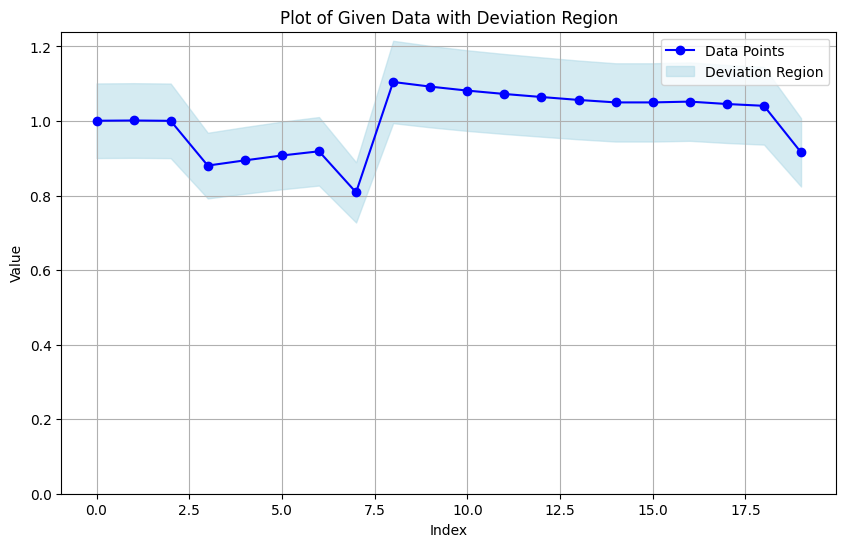

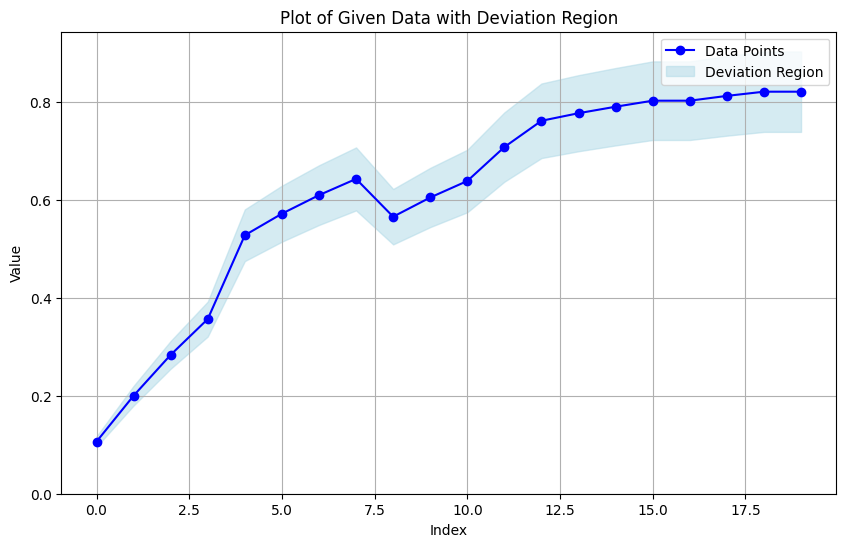

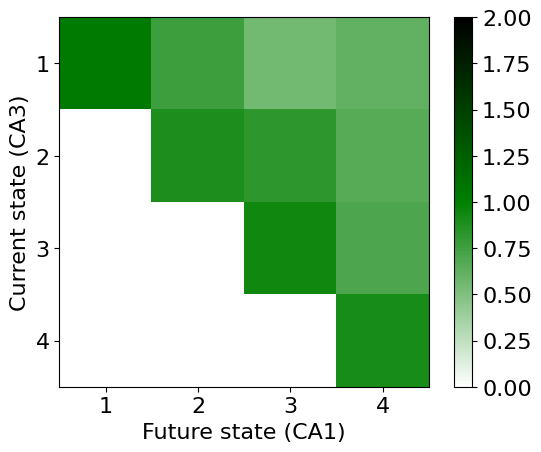

In [9]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "MC", # mode, can be MC, TD or MX
        }
run_simulation(conf_figure)

## TD Lambda Active Exploration 

Calculating TD lambda spiking ....


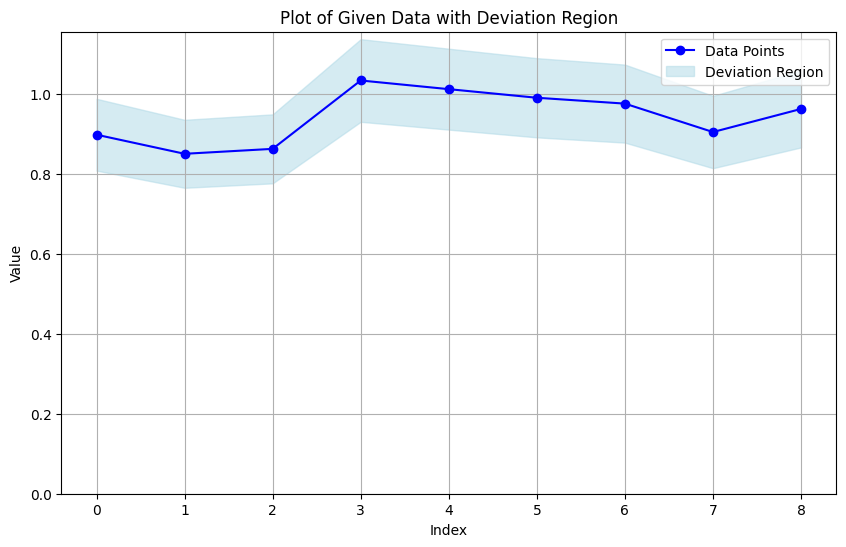

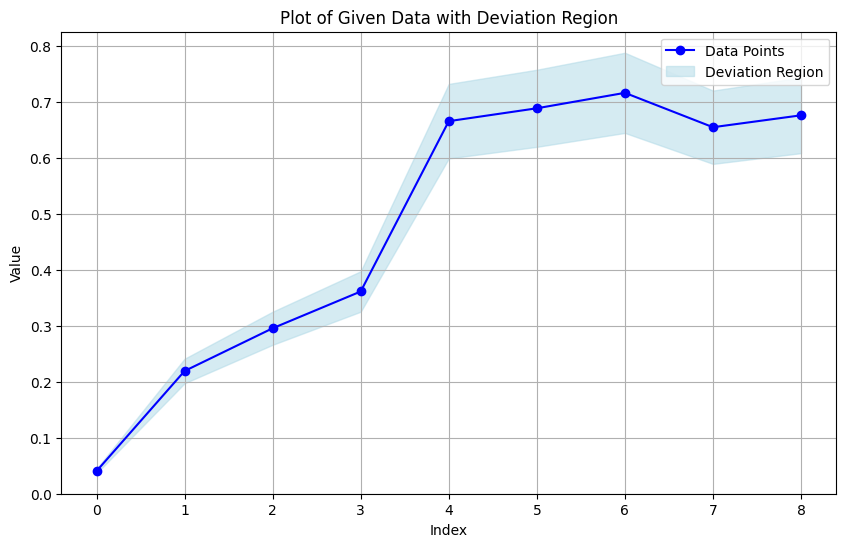

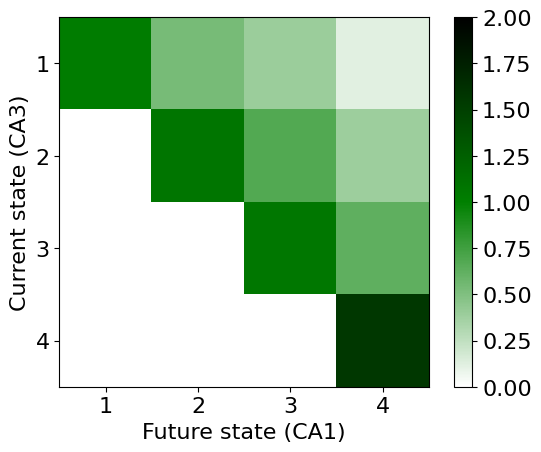

In [10]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 10, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "TD", # mode, can be MC, TD or MX
        }
run_simulation(conf_figure)

## Q Learning Active Exploration 

Running Q-learning with spiking neurons...


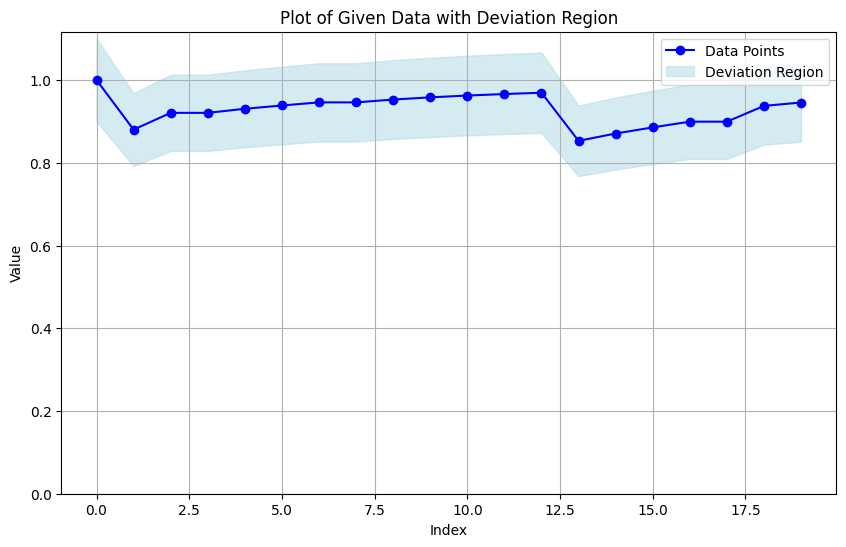

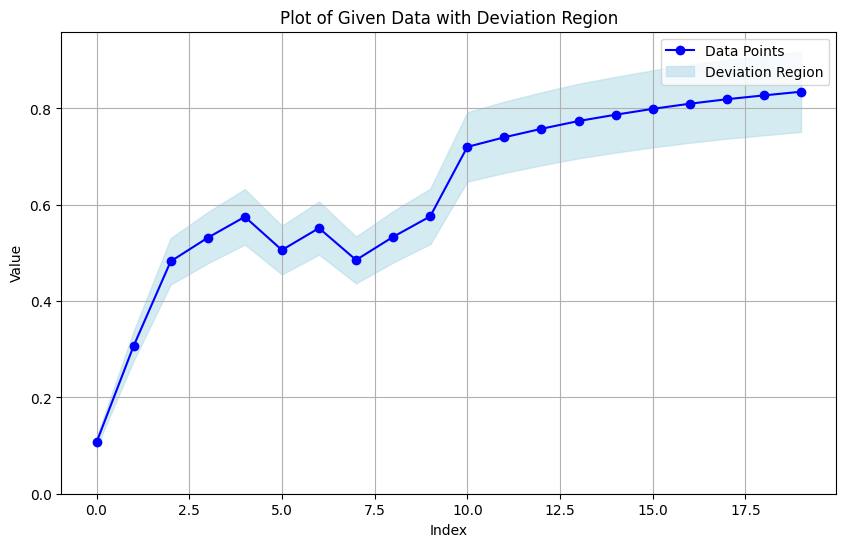

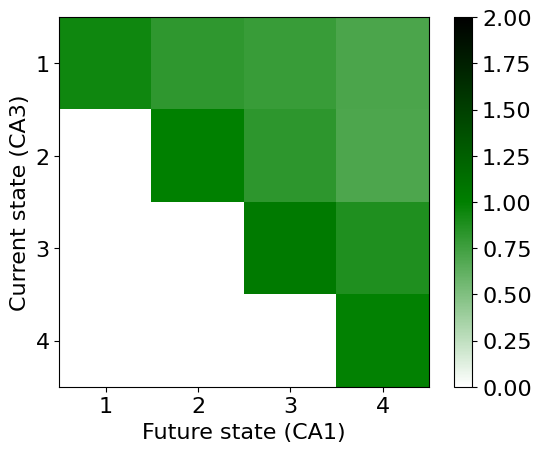

In [109]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "Q", # mode, can be MC, TD or MX
        }
run_simulation(conf_figure)

## Monte Carlo Replays

Calculating TD(1) spiking ....


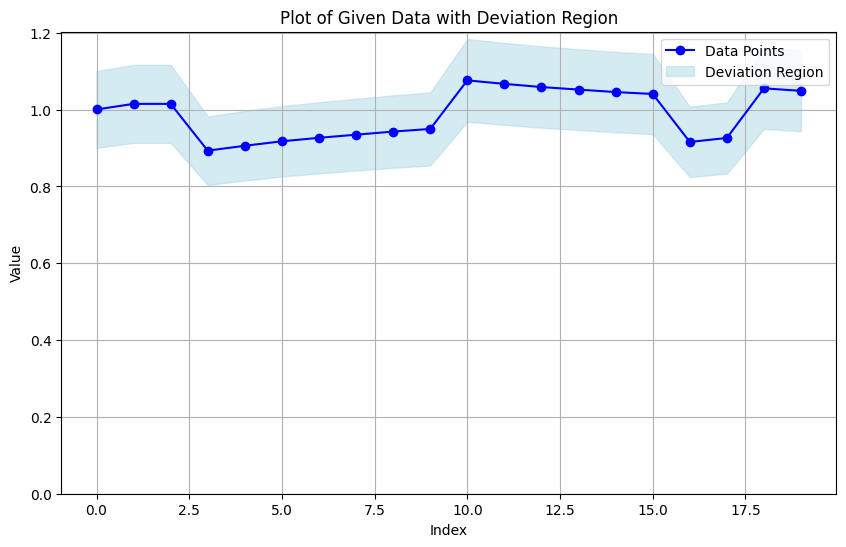

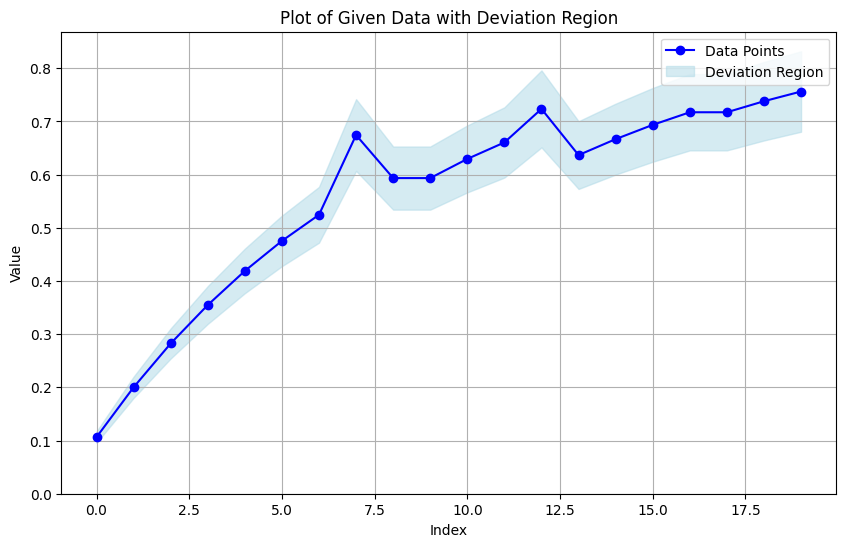

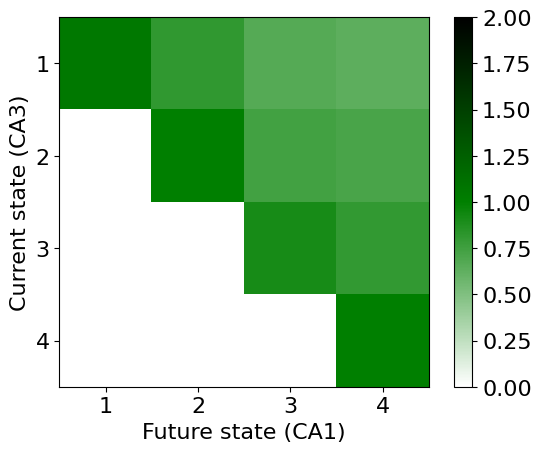

In [121]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "MC", # mode, can be MC, TD or MX
        'time_list': [[10, 10, 10, 10]]
        }
run_simulation(conf_figure)

## TD Lambda Replays

Calculating TD lambda spiking ....


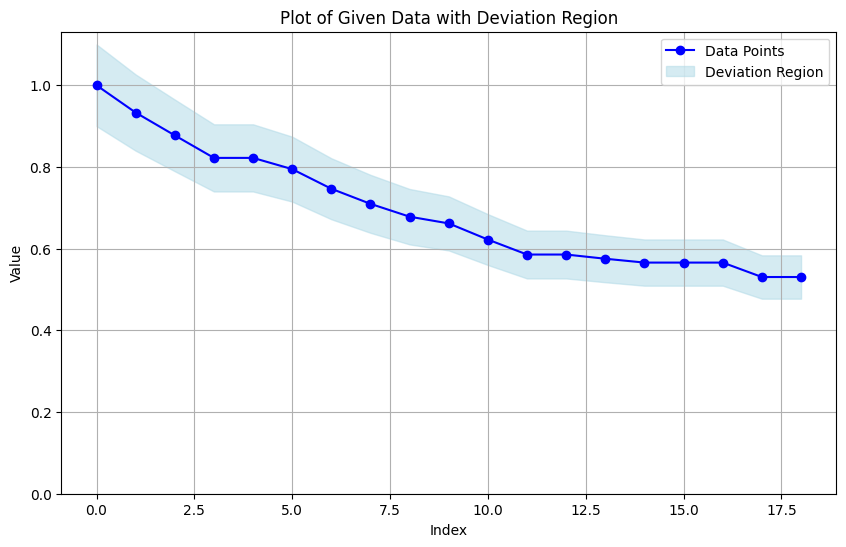

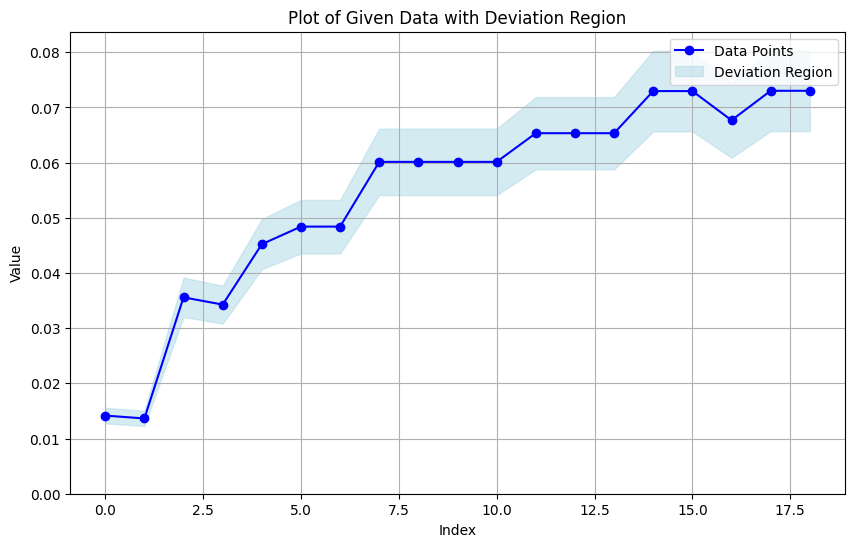

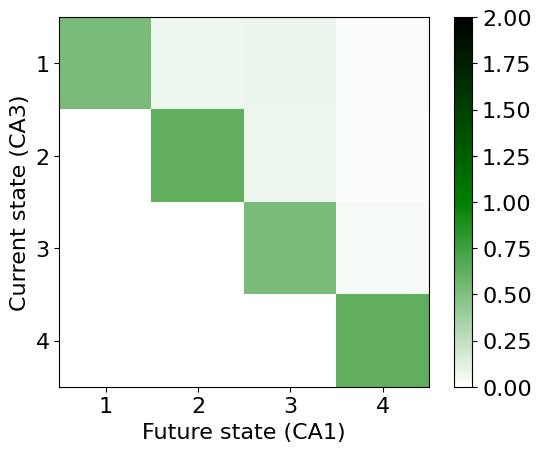

In [122]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "TD", # mode, can be MC, TD or MX
        'time_list': [[10, 10, 10, 10]]
        }
run_simulation(conf_figure)

## Q Learning Replays

Running Q-learning with spiking neurons...


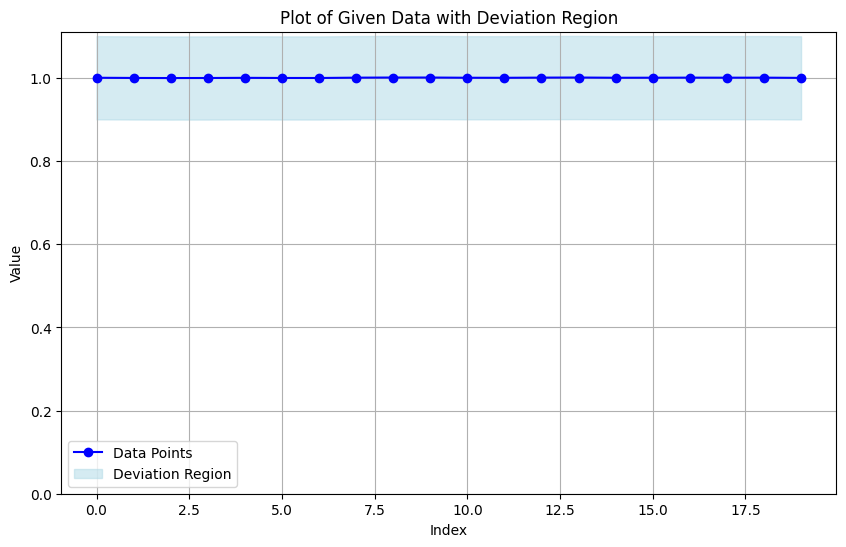

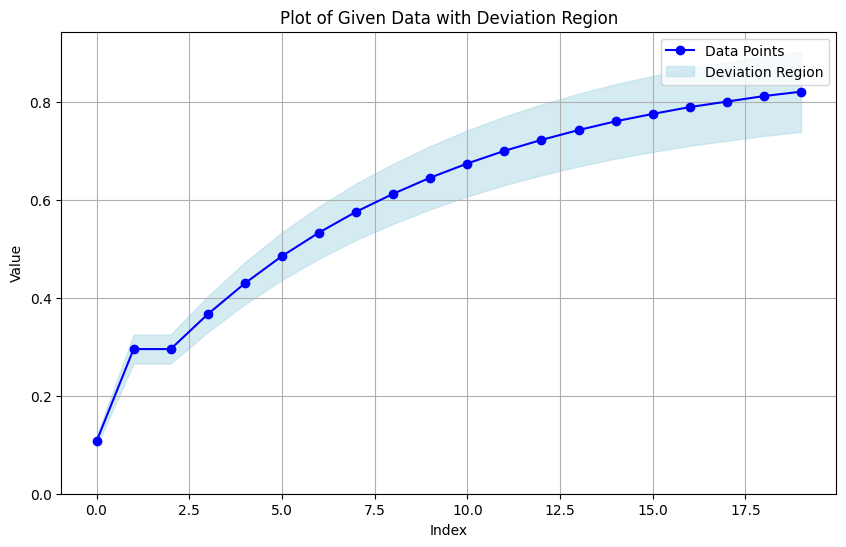

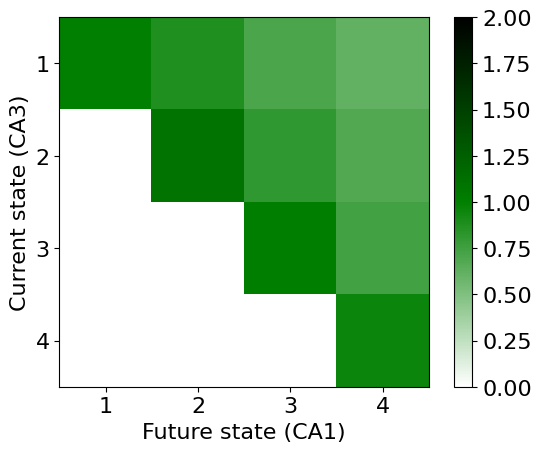

In [123]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "Q", # mode, can be MC, TD or MX
        'time_list': [[10, 10, 10, 10]]
        }
run_simulation(conf_figure)

## Experimenting with parameters

### 1. Time spent in state 3 is doubled 

Calculating TD(1) spiking ....


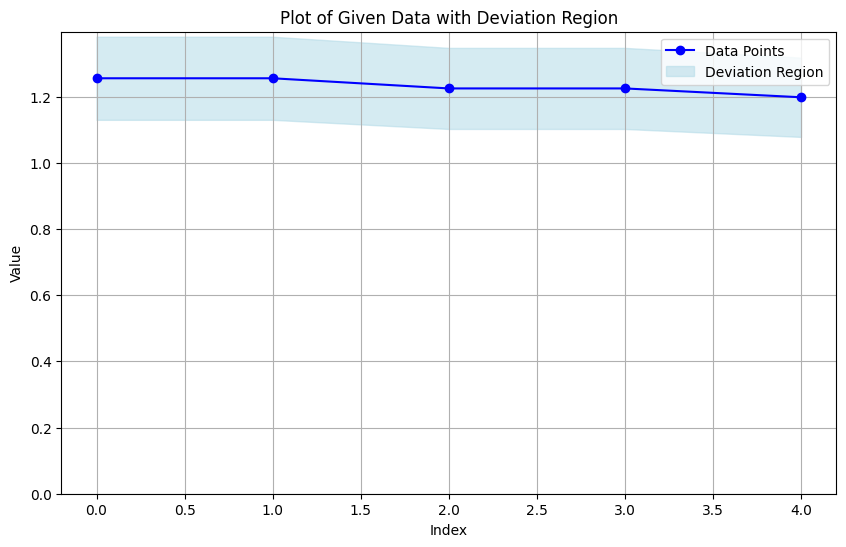

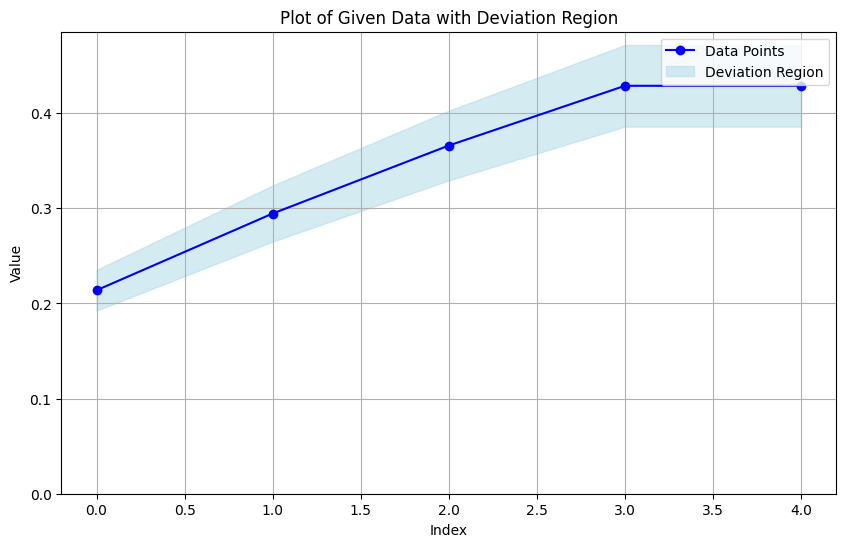

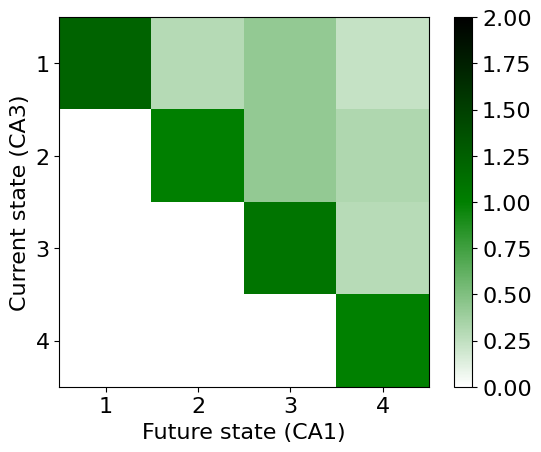

In [141]:
conf_figure = {
        'state_3_T': 200, # time in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 5, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "MC", # mode, can be MC, TD or MX
        'time_list': [[100, 100, 200, 100]]
        }
run_simulation(conf_figure)

### 2. CA3 firing rate in state 3 is doubled 

Calculating TD(1) spiking ....


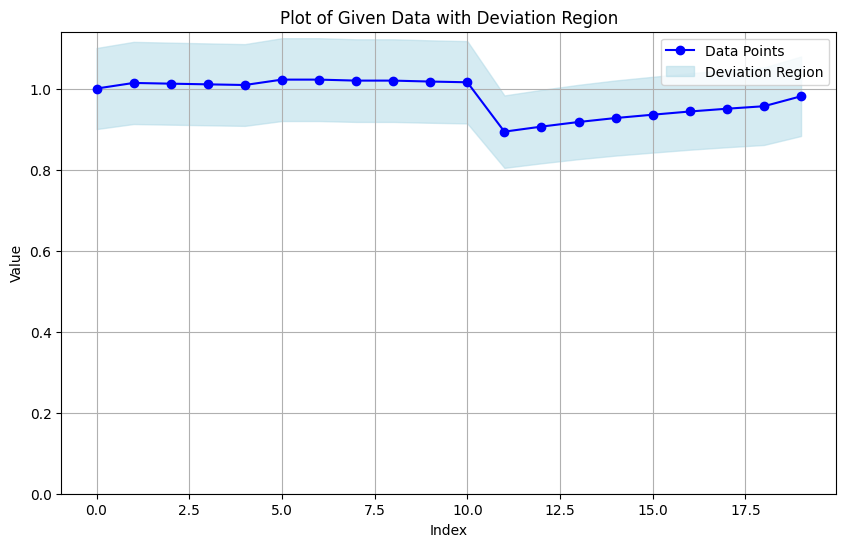

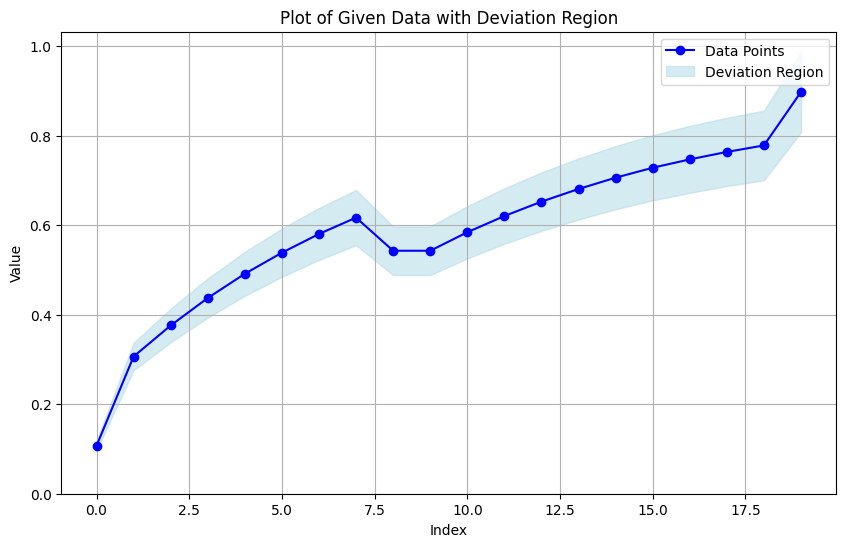

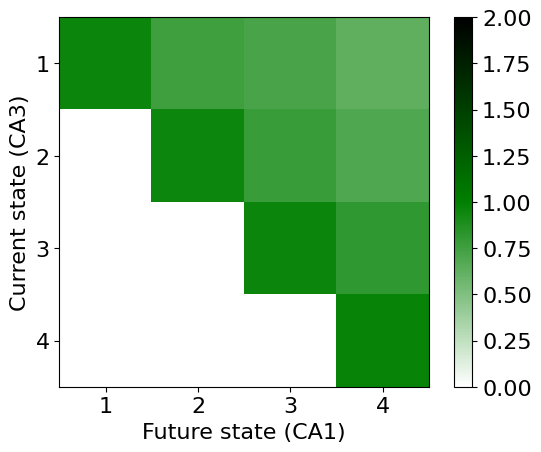

In [86]:
conf_figure = {
        'state_3_T': 100, # time in state 3
        'state_3_rate': 2, # multiplier for the rate in state 3
        'experiment_folder': "simulations_figure2", # folder to store
        'initial_trial_nr': 1, # initial trial number
        'final_trial_nr': 2, # final trial number
        'nr_epochs': 20, # number of epochs per trial
        'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
        'multiprocessing': False, # whether to run in parallel using multiprocessing
        'store_data': False, # whether to store the experiment data
        'mode': "MC", # mode, can be MC, TD or MX
        }
run_simulation(conf_figure)

In [143]:
def fun_to_run(traj):

    traj,nr,ini,path, tlist, mode, store_data = traj
    # print(nr)

    params, gamma, eta, lambda_var = parameters_linear_track(no_states=3)
    params['trajectories'] = traj

    params = update_params(mode, params, tlist, gamma, eta, state_3_rate=1)

    if mode == 'TD':
        M_stdp = run_td_lambda_new_continuousTime(**params)
        print(M_stdp)

    if mode == 'MC':
        M_stdp, store1, store2 = run_MC(**params)
    elif mode == 'Q':
        M_stdp, Q, store1, store2 = run_Q_learning(**params)

    if mode == 'MX':
        Trials = len(traj)
        tau = 6 #
        ratios = np.exp(-1*np.arange(Trials)/tau)
        M_stdp = np.zeros((Trials, params['no_states'], params['no_states']))
        w = []
        for trial in range(Trials):
            params, _, _, _ = parameters_linear_track(no_states=3)
            params['trajectories'] = [traj[trial]]
            params['w'] = w
            if np.random.rand()<ratios[trial]:
                params = update_params('MC', params, [tlist[trial]], gamma, eta, state_3_rate=1)
                w = run_MC(**params)
                w = w[0]
            else:
                params = update_params('TD', params, [tlist[trial]], gamma, eta, state_3_rate=1)
                w = run_td_lambda_new_continuousTime(**params)
                w = w[-1,:,:,0,0]
            M_stdp[trial] = w
            w = np.tile(np.expand_dims(np.expand_dims(w, axis=2), axis=3), [1, 1, params['N_pre_tot'], params['N_post']])


    if store_data:
        with open(path+f'/{mode}_traj_{ini+nr}.pkl','wb') as f:
            pickle.dump(M_stdp,f)

    return M_stdp

def update_params(mode, params, T_lists, gamma, eta, state_3_rate):

    if mode == 'TD':
        params['offline'] = False
        params['T_lists'] = T_lists
        params['state_3_rate'] = state_3_rate
        del params['T']
    if mode == 'MC':
        temporal_same = 2
        temporal_between = -np.log(gamma)*params['tau_plus']
        params['temporal_same'] = temporal_same
        params['temporal_between'] = temporal_between
        params['eta_stdp'] = eta/(params['A_plus']*np.exp(-temporal_same/params['tau_plus']))
        params['spike_noise_prob'] = 0.15
        params['pre_offset'] = 5
        # eta_replay = params['eta_stdp'] *params['A_plus']*np.exp(-temporal_same/params['tau_plus'])
        # gamma_replay = np.exp(-temporal_between/params['tau_plus'])
    elif mode == 'Q':  # New Q-learning parameters
        params['alpha'] = 0.1  # Learning rate
        params['gamma'] = gamma  # Discount factor
        params['epsilon'] = 0.2  # Exploration rate
        params['pre_offset'] = 1  # Timing offset for pre-synaptic spikes
        temporal_same = 2 + params['pre_offset']  # Adjusted for pre-synaptic offset
        temporal_between = -np.log(gamma)*params['tau_plus']
        params['temporal_same'] = temporal_same
        params['temporal_between'] = temporal_between
        params['eta_stdp'] = eta/(params['A_plus']*np.exp(-temporal_same/params['tau_plus']))
        params['spike_noise_prob'] = 0.15
    return params

def generate_traj():
    traj = [1]
    state = 1
    while state > -1 and state < 3:
        next_state = state + random.choice([-1,1])
        traj.append(next_state)
        state = next_state
    return traj[:-1]

def root_mse(M_est, M_theor, cutoff=0):
    # trials, epochs, state, state
    mse = ((((M_est-M_theor)**2).mean(axis=0))**0.5).mean(axis=1).mean(axis=1)
    stderr = ((((M_est-M_theor)**2).mean(axis=2).mean(axis=2))**0.5).std(axis=0)/np.sqrt(len(M_est))
    return mse[cutoff:], stderr[cutoff:]


def create_path(conf: dict):
    """
    Create experiment path.

    Parameters
    ----------
    conf: dict
        Dict of the yaml configuration file.
    logg: LOGG
        Logger object.

    Returns
    -------
    newpath: str
        Path to experiment folder.
    """

    # Create experiment folder
    date_time = str(datetime.datetime.now()).split('.')[0].replace('-','_').replace(':','_').replace(' ','_')
    newpath = os.path.join(conf.experiment_folder, date_time)

    newpath = f'{conf.mode}_runs/'+newpath

    # Create storage folder
    if conf.store_data:
        os.makedirs(newpath)
        print('Folder {} created!'.format(newpath))

    return newpath

def validate_conf(conf: dict) -> SimpleNamespace :
    """
    Validate the hyperparameters in the dictionary.

    Parameters
    ----------
    conf : dict
        Dictionary containing hyperparemeters to run the simulation.

    Returns
    -------
    SimpleNamespace
        Namespace containing the validated hyperparameters.

    """
    valid_conf = Schema({
        Optional('state_3_T', default=100): And(int, lambda s: s in [100]),
        Optional('experiment_folder', default="simulation"): str,
        Optional('initial_trial_nr', default=1): And(int, lambda s: s>0),
        Optional('final_trial_nr', default=2): And(int, lambda s: s>0),
        Optional('nr_epochs', default=2): And(int, lambda s: s>0),
        # Optional('nr_states', default=10): And(int, lambda s: s>2),
        Optional('cpu_percentage', default=0.9): And(float, lambda s: s>0,
                                                     lambda s: s<=1),
        Optional('multiprocessing', default=False): bool,
        Optional('store_data', default=False): bool,
        Optional('mode', default="MC"): And(str, lambda s: s in ['TD', 'MC', 'MX', 'Q']),
        Optional('state_3_rate', default=1): And(int, lambda s: s in [1]),
        }).validate(conf)

    assert valid_conf['final_trial_nr'] > valid_conf['initial_trial_nr'], 'ERROR: Number of final trial should be larger than number of initial trial!'

    return SimpleNamespace(**valid_conf)


def run_simulation(conf):
    """
    Run a simulation on the linear track.

    Parameters
    ----------
    """

    # validate cofiguration
    conf = validate_conf(conf)

    # Define total number of trials
    tot_trials = conf.final_trial_nr-conf.initial_trial_nr

    # Define total number of trials
    tot_trials = conf.final_trial_nr-conf.initial_trial_nr

    # Define trajectory and time per state
    nr_states = 3
    traj = [ [generate_traj() for _ in  range(conf.nr_epochs)] for _ in range(tot_trials)]
    T_list = [[[100]*len(t) for t in tt] for tt in traj]

    # Define function to run and storage path
    newpath = create_path(conf)


    # Run in parallel if set
    if conf.multiprocessing:
        cc = int(conf.cpu_percentage*cpu_count())
        print(f'Using max {cc} cpus...')
        pool = Pool(cc)
        output = pool.map(lambda x: fun_to_run(x),
                          zip(traj,range(len(traj)),[conf.initial_trial_nr]*len(traj),
                                          [newpath]*len(traj), T_list,
                                          [conf.mode]*len(traj),
                                          [conf.store_data]*len(traj),
                                          ) )
        outputs=np.array(output)
    else:
        output = []
        for idx,tt in enumerate(traj):
            output.append(fun_to_run((tt,idx,conf.initial_trial_nr,
                                newpath, T_list[idx],conf.mode,
                                conf.store_data,
                                )
                                     )
                          )
        # print(output)
        outputs=np.array(output)


    # cumulative lengths
    l = [np.cumsum([len(x) for x in t]) for t in traj]
    # params, gamma_var, _, _ = fetch_parameters_new()
    params, gamma_var, _, _ = parameters_linear_track(nr_states)
    if conf.mode == 'TD':
        w_stdps = np.array([[outputs[i][l_i] for l_i in l[i]] for i in range(len(outputs))])
        w_stdps2 = np.mean(np.sum(w_stdps[:,:,:,:,:,:],axis=-2)/params['N_pre'],axis=-1)
    elif conf.mode == 'MC':
        w_stdps2 = outputs #np.array(outputs)
    elif conf.mode == 'Q':
        w_stdps2 = outputs 
    elif conf.mode == 'MX':
        w_stdps2 = outputs

    if conf.store_data:
        pickle.dump(w_stdps2, open(newpath + '/Fig4_w_stdps2.pkl','wb'))


    T_mat = np.array(
            [[0,0.5,0,0.5],
             [0.5,0,0.5,0],
             [0,0.5,0,0.5],
             [0,0,0,1],
             ]
        )
    M_theor = np.linalg.inv(np.eye(3)-gamma_var*T_mat[:-1,:-1])

    plt.figure()
    root_mse_spiking,stderr = root_mse(w_stdps2, M_theor, 0)
    plt.plot(root_mse_spiking)
    plt.fill_between(range(len(stderr)), root_mse_spiking-stderr, root_mse_spiking+stderr,alpha=.3)
    plt.show()

## RMSE scores

### MC stdp

Calculating TD(1) spiking ....
Calculating TD(1) spiking ....


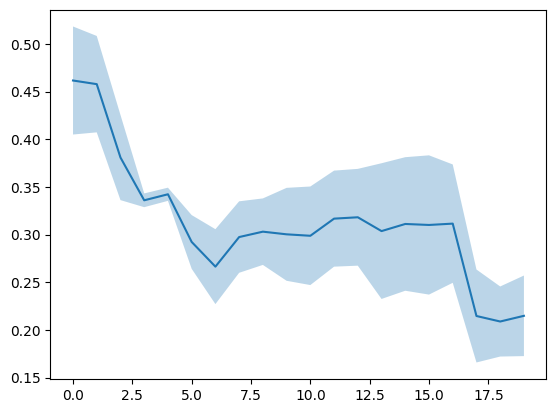

In [144]:
conf_figure4 = {
    'experiment_folder': "simulations_figure4", # folder to store
    'initial_trial_nr': 1, # initial trial number
    'final_trial_nr': 3, # final trial number
    'nr_epochs': 20, # number of epochs per trial
    'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
    'multiprocessing': False, # whether to run in parallel using multiprocessing
    'store_data': False, # whether to store the experiment data
    'mode': "MC", # mode, can be MC, TD or MX or Q
    }

run_simulation(conf_figure4)

### TD stdp

In [89]:

# conf_figure = {
#     'experiment_folder': "simulations_figure4", # folder to store
#     'initial_trial_nr': 1, # initial trial number
#     'final_trial_nr': 3, # final trial number
#     'nr_epochs': 1, # number of epochs per trial
#     'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
#     'multiprocessing': False, # whether to run in parallel using multiprocessing
#     'store_data': False, # whether to store the experiment data
#     'mode': "TD", # mode, can be MC, TD or MX or Q
#     }

# run_simulation(conf_figure)


### MX stdp 

In [90]:

# conf_figure4 = {
#     'experiment_folder': "simulations_figure4", # folder to store
#     'initial_trial_nr': 1, # initial trial number
#     'final_trial_nr': 3, # final trial number
#     'nr_epochs': 1, # number of epochs per trial
#     'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
#     'multiprocessing': False, # whether to run in parallel using multiprocessing
#     'store_data': False, # whether to store the experiment data
#     'mode': "MX", # mode, can be MC, TD or MX or Q
#     }

# run_simulation(conf_figure4)

### Q stdp

Running Q-learning with spiking neurons...
Running Q-learning with spiking neurons...


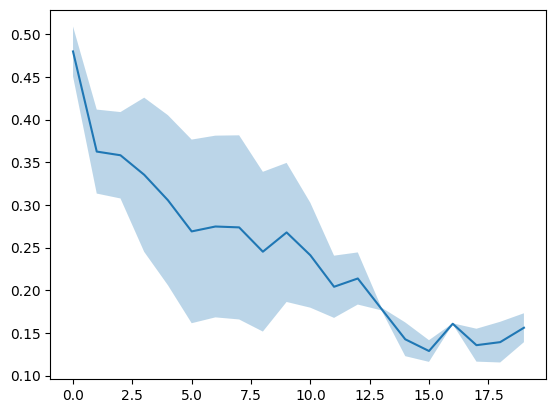

In [146]:

conf_figure4 = {
    'experiment_folder': "simulations_figure4", # folder to store
    'initial_trial_nr': 1, # initial trial number
    'final_trial_nr': 3, # final trial number
    'nr_epochs': 20, # number of epochs per trial
    'cpu_percentage': 0.9, # percentage of cpus to use when running in parallel
    'multiprocessing': False, # whether to run in parallel using multiprocessing
    'store_data': False, # whether to store the experiment data
    'mode': "Q", # mode, can be MC, TD or MX or Q
    }

run_simulation(conf_figure4)

In [150]:
#%%

nr_states = 21
epochs = ['pre', 'post']

neg_reward = -2
replay_prob=1

tot_steps = 4000

gamma = .9
alpha = .1


#%%

def transition(M,
               elig_trace,
               reward,
               tot_steps,
               curr_state,
               prev_state,
               gamma,
               alpha,
               traj,
               replays=False,
               neg_reward = 0):

    n_states = np.shape(M)[0]

    ## REPLAYS
    if replays and curr_state == 10 and prev_state==11 and reward[0]<0:
        if np.random.rand()<replay_prob:
            M = theor_trajectory([10-x for x in range(11)],
                    n_states,
                    gamma,
                    1,
                    alpha,
                    M)
    ## SET SHOCK
    if curr_state == reward[0]:
        reward[0] = neg_reward

    ## UPDATE VALUE
    V = np.dot(M,reward)

    ## CHOOSE NEXT STATE
    possible_next = [curr_state-1] if curr_state>0 else []
    if curr_state<nr_states-1:
        possible_next.append(curr_state+1)

    probabilities = softmax([V[j] for j in possible_next])

    if np.random.rand() < probabilities[0]:
        next_state = possible_next[0]
    else:
        next_state = possible_next[1]

    traj.append(next_state)

    ## UPDATE M, e
    M, elig_trace = TD_lambda_update(
                        curr_state,
                        next_state,
                        gamma,
                        0,
                        alpha,
                        elig_trace,
                        M
                        )
    prev_state = curr_state
    curr_state = next_state

    return M, elig_trace, prev_state, curr_state, reward, traj, V

def make_traj(M,
              reward,
              tot_steps,
              curr_state,
              gamma,
              alpha,
              replays=False,
              neg_reward = 0
              ):
    traj = [curr_state]
    prev_state=curr_state

    # Initialize eligibility trace
    n_states = np.shape(M)[0]
    elig_trace = np.zeros(n_states)

    if neg_reward<0:
        # Explore until shock
        while reward[0]==0:
            M, elig_trace, prev_state, curr_state, reward, traj, V = transition(M,
                   elig_trace,
                   reward,
                   tot_steps,
                   curr_state,
                   prev_state,
                   gamma,
                   alpha,
                   traj,
                   replays=replays,
                   neg_reward=neg_reward)

        # Reset
        curr_state=20
        prev_state=20
        traj = [curr_state]

    for i in range(tot_steps):
        M, elig_trace, prev_state, curr_state, reward, traj, V = transition(M,
               elig_trace,
               reward,
               tot_steps,
               curr_state,
               prev_state,
               gamma,
               alpha,
               traj,
               replays=replays,
               neg_reward=neg_reward)

    return traj,V,M

#%%

ts = []

for tt in range(50):
    all_traj = [[],[]]
    all_vals = [[],[]]
    all_M = [[],[]]

    for j,replays in enumerate([False, True]):
        reward = np.zeros(nr_states)
        curr_state = nr_states-1
        M = np.eye(nr_states)
        for t in epochs:
            n = neg_reward if t=='post' else 0
            traj,V,M = make_traj(M, reward, tot_steps, curr_state, gamma, alpha, replays=replays, neg_reward = n)

            all_traj[j].append(traj)
            all_vals[j].append(V)
            all_M[j].append(M)
    ts.append(all_traj)

#%%
# import seaborn as sns
# import pandas as pd

lw = 4
fs = 17

nstates = len(set(ts[0][0][-1]))

no_replays = []
replays = []
pr = []
for x in ts:
    p,_ = np.histogram(x[0][0], bins=nstates)
    h1,_ = np.histogram(x[0][-1], bins=nstates)
    h2,_ = np.histogram(x[1][-1], bins=nstates)
    no_replays.append(h1)
    replays.append(h2)
    pr.append(p)

no_replays = np.array(no_replays)
replays = np.array(replays)
pre = np.array(pr)

p1, ps1 = np.mean(pre, axis=0),np.std(pre, axis=0)
m1, s1 = np.mean(no_replays, axis=0),np.std(no_replays, axis=0)
m2, s2 = np.mean(replays, axis=0),np.std(replays, axis=0)

Text(0, 0.5, 'Nr of visits')

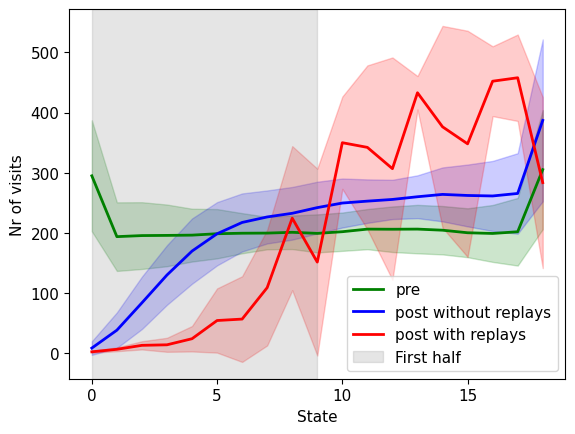

In [153]:
fs = 11
lw = 2
plt.figure()
plt.plot(p1, c='g', linewidth = lw, label='pre')
plt.fill_between(range(nstates), p1-ps1, p1+ps1, color='g', alpha=.2)
plt.plot(m1, c='b', linewidth = lw, label='post without replays')
plt.fill_between(range(nstates), m1-s1, m1+s1, color='b', alpha=.2)
plt.plot(m2, c='r', linewidth = lw, label='post with replays')
plt.fill_between(range(nstates), m2-s2, m2+s2, color='r', alpha=.2)
# Add a grayish shaded region in the first half of the plot
half_nstates = nstates // 2  # Calculate half the number of states
plt.axvspan(0, half_nstates, color='gray', alpha=0.2, label='First half')

plt.legend(fontsize=fs)
plt.xticks(list(range(0,20,5)),fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('State', fontsize=fs)
plt.ylabel('Nr of visits', fontsize=fs)
# plt.savefig('fig5_occupancy.eps',bbox_inches='tight')

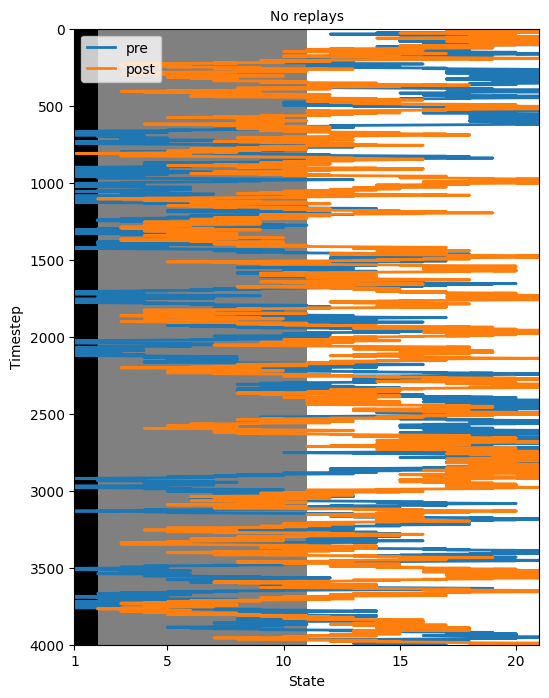

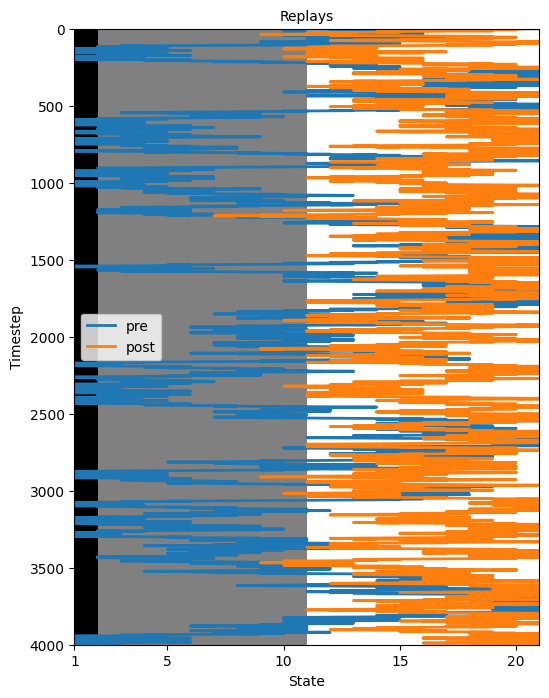

In [101]:

#%%
fs = 10
lw = 2
for p in [0,1]:
    plt.figure(figsize=(6,8))
    plt.plot(all_traj[p][0],np.arange(tot_steps+1),label='pre',linewidth=lw)
    plt.plot(all_traj[p][-1],np.arange(tot_steps+1), label='post',linewidth=lw)
    r = plt.Rectangle([0,0], 10, tot_steps, fc='grey')
    r2 = plt.Rectangle([0,0], 1, tot_steps, fc='black')
    plt.gca().add_patch(r)
    plt.gca().add_patch(r2)
    plt.xlim([0,20])
    plt.ylim([tot_steps,0])
    plt.xticks(ticks=[0]+[x for x in range(4,21,5)], labels=[1]+[x+1 for x in range(4,21,5)],fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('State', fontsize=fs)
    plt.ylabel('Timestep', fontsize=fs)
    plt.legend(fontsize=fs)
    if p==0:
        plt.title('No replays',fontsize=fs)
    else:
        plt.title('Replays', fontsize=fs)
    # plt.savefig(f'fig5_replays_{p}.eps',bbox_inches='tight')

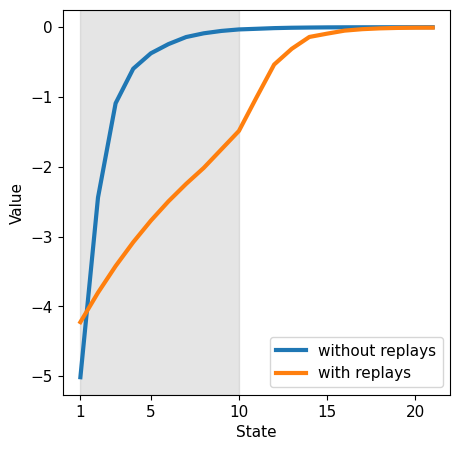

In [154]:
#%%
lw = 3
fs = 11

plt.figure(figsize=(5,5))
plt.plot(all_vals[0][-1], label='without replays', linewidth=lw)
plt.plot(all_vals[1][-1], label='with replays', linewidth=lw)
plt.ylabel('Value', fontsize=fs)
plt.xlabel('State', fontsize=fs)
plt.xticks(ticks=[0]+[x for x in range(4,21,5)], labels=[1]+[x+1 for x in range(4,21,5)],fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
# Add a grayish shaded region in the first half of the plot
half_nstates = nstates // 2  # Calculate half the number of states
plt.axvspan(0, half_nstates, color='gray', alpha=0.2, label='First half')

plt.savefig(f'fig5_value.eps',bbox_inches='tight')

/tmp/ipykernel_30/2449276112.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Greens', 128)


Text(0.5, 1.0, 'Without replays')

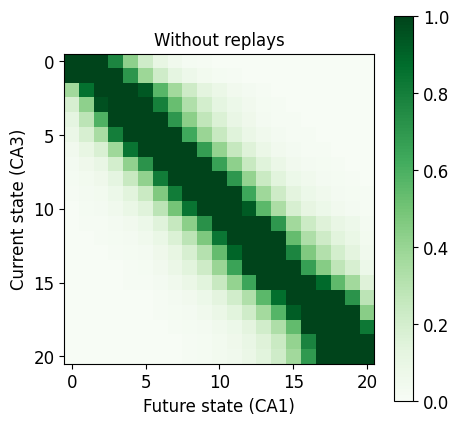

In [103]:
#%%
fs = 12

from matplotlib import cm
top = cm.get_cmap('Greens', 128)

plt.figure(figsize=(5,5))
plt.imshow(all_M[0][-1],cmap=top,vmin=0,vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fs)
plt.xticks([x for x in range(0,21,5)],fontsize=fs)
plt.yticks([x for x in range(0,21,5)],fontsize=fs)
plt.xlabel('Future state (CA1)',fontsize=fs)
plt.ylabel('Current state (CA3)',fontsize=fs)
plt.title('Without replays', fontsize=fs)
# plt.savefig('fig5_SR_0.eps',bbox_inches='tight')

Text(0.5, 1.0, 'With replays')

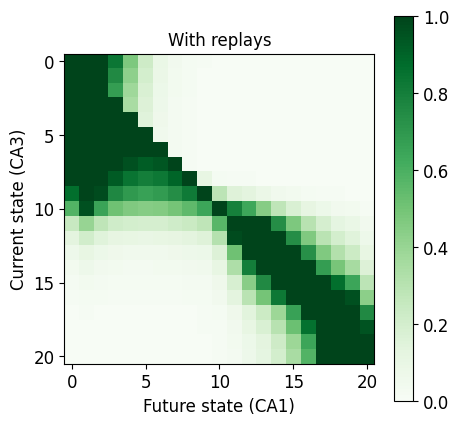

In [104]:
plt.figure(figsize=(5,5))
plt.imshow(all_M[1][-1],cmap=top,vmin=0,vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fs)
plt.xticks([x for x in range(0,21,5)],fontsize=fs)
plt.yticks([x for x in range(0,21,5)],fontsize=fs)
plt.xlabel('Future state (CA1)',fontsize=fs)
plt.ylabel('Current state (CA3)',fontsize=fs)
plt.title('With replays', fontsize=fs)
# plt.savefig('fig5_SR_1.eps',bbox_inches='tight')